In [ ]:
!pip install pyradiomics

In [ ]:
import numpy as np
import os, csv, gc, pickle
import nibabel as nib
import sys
import glob
from radiomics import featureextractor,firstorder, getTestCase, glcm, glrlm, glszm,ngtdm,gldm, imageoperations, shape
import SimpleITK as sitk
import pandas as pd
import pickle
import math
import csv
import six
from openpyxl import Workbook
#import get_segmentation

In [ ]:
paramPath = os.path.join(os.getcwd(), "..", "Params.yaml")
print ("Parameter file, absolute path:", os.path.abspath(paramPath))

Parameter file, absolute path: /Params.yaml


In [ ]:
#for training dataset
HGG_data_path = "/content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess"
output_data_path = "/content/drive/MyDrive/OS_prediction_Triplanar/TrainOS_ens_9_mod_pred_postp"
survival_csv_path = "/content/drive/MyDrive/OS_prediction_Triplanar/survival_info_gtr.csv"

###==========================================================================###
#for validation dataset
#validation
#HGG_data_path = "/content/drive/MyDrive/OS_prediction_Triplanar/Validation2020"
#output_data_path = "/content/drive/MyDrive/OS_prediction_Triplanar/Val_ensemble_9models_supr_ens"
#survival_csv_path = "/content/drive/MyDrive/OS_prediction_Triplanar/survival_evaluation.csv"

#for test dataset
#HGG_data_path = "/content/drive/MyDrive/brats1/data/preprocessed/test_2020"
#output_data_path = "/content/drive/MyDrive/brats1/data/preprocessed/BraTS2020_Test_predictions_es80"
#survival_csv_path = "/content/drive/MyDrive/brats1/data/preprocessed/test_2020/survival_evaluation (1).csv"

csv_data=[]
print(HGG_data_path, output_data_path, survival_csv_path)

#HGG_path_list = tl.files.load_folder_list(path=HGG_data_path)
#print(len(HGG_path_list))
#HGG_name_list = [os.path.basename(p) for p in HGG_path_list]
survival_id_list = []

#with open(survival_csv_path, 'rw') as f:

with open(survival_csv_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for idx, content in enumerate(reader):
        #for training
        #csv_data.append({'ID':content[0] ,'Resection Status':content[3],'Survival Days':content[2],'Age':content[1]})
        #for validation
         #for validation
        csv_data.append({'ID':content[0] ,'Resection Status':content[2],'Survival Days':0,'Age':content[1]})
        survival_id_list.append(content[0])



##==================== GET NORMALIZE IMAGES


necroticlist =[]
edemalist =[]
enhancinglist=[]
alltlist=[]

featureName = ["original_shape_Elongation","original_shape_Flatness","original_shape_LeastAxisLength","original_shape_MajorAxisLength", "original_shape_Maximum2DDiameterColumn", "original_shape_Maximum2DDiameterRow", "original_shape_Maximum2DDiameterSlice","original_shape_Maximum3DDiameter", "original_shape_MeshVolume", "original_shape_MinorAxisLength","original_shape_Sphericity","original_shape_SurfaceArea","original_shape_SurfaceVolumeRatio"]
featureNameglcm= ["Autocorrelation","ClusterProminence","ClusterShade","ClusterTendency","Contrast","Correlation","DifferenceAverage","DifferenceEntropy","DifferenceVariance","Id","Idm","Idmn","Idn","Imc1","Imc2","InverseVariance","JointAverage","JointEnergy","JointEntropy","MCC","MaximumProbability","SumAverage","SumEntropy","SumSquares"]
featurefirstorder= ["10Percentile","90Percentile","Energy","Entropy","Range","Minimum","Maximum","Mean","Median","InterquartileRange","MeanAbsoluteDeviation","RootMeanSquared","Skewness","Kurtosis","TotalEnergy","RobustMeanAbsoluteDeviation","Uniformity","Variance"]
featureNameglrlm=["ShortRunEmphasis","LongRunEmphasis","GrayLevelNonUniformity","GrayLevelNonUniformityNormalized","RunLengthNonUniformity","RunLengthNonUniformityNormalized","RunPercentage","GrayLevelVariance","RunVariance","RunEntropy","LowGrayLevelRunEmphasis","HighGrayLevelRunEmphasis","ShortRunLowGrayLevelEmphasis","ShortRunHighGrayLevelEmphasis","LongRunLowGrayLevelEmphasis","LongRunHighGrayLevelEmphasis"]
featureNameglszm=["SmallAreaEmphasis","LargeAreaEmphasis","SizeZoneNonUniformity","SizeZoneNonUniformityNormalized","ZonePercentage","ZoneVariance","ZoneEntropy","LowGrayLevelZoneEmphasis","SmallAreaLowGrayLevelEmphasis","SmallAreaHighGrayLevelEmphasis","LargeAreaLowGrayLevelEmphasis","LargeAreaHighGrayLevelEmphasis"]
featureNamengtdm=["Coarseness","Busyness","Complexity","Strength"]
featureNamegldm=["SmallDependenceEmphasis","LargeDependenceEmphasis","DependenceNonUniformity","DependenceNonUniformityNormalized","DependenceVariance","DependenceEntropy","LowGrayLevelEmphasis","HighGrayLevelEmphasis","SmallDependenceLowGrayLevelEmphasis","SmallDependenceHighGrayLevelEmphasis","LargeDependenceLowGrayLevelEmphasis","LargeDependenceHighGrayLevelEmphasis"]
settings = {}
#settings['force2D'] = True
settings['gradientUseSpacing']= True
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = sitk.sitkBSpline
settings['verbose']=True
def get_length(b):
        return np.sum(np.sqrt(b[0] * b[0] + b[1] * b[1] + b[2] * b[2]))
# Initialize feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
print("Extraction parameters:\n\t", extractor.settings)
extractor.disableAllImageTypes()
#extractor.enableAllImageTypes()#Original,Exponential,Gradient,LBP2D,LBP3D,LoG,Logarithm,Square,SquareRoot,Wavelet
extractor.enableImageTypes(Wavelet={}, LoG={'sigma':[1.0, 2.0, 3.0, 4.0, 5.0]})#,Gradient={}, Square={})
print('Enabled input images:')
for imageType in extractor.enabledImagetypes.keys():
    print('\t' + imageType)
extractor.enableAllFeatures()
#extractor.enableFeatureClassByName('firstorder')
print("Enabled features:\n\t", extractor.enabledFeatures)


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'gradientUseSpacing': True, 'binWidth': 25, 'resampledPixelSpacing': None, 'interpolator': 23, 'verbose': True}


/content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess /content/drive/MyDrive/OS_prediction_Triplanar/TrainOS_ens_9_mod_pred_postp /content/drive/MyDrive/OS_prediction_Triplanar/survival_info_gtr.csv
Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 23, 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'gradientUseSpacing': True, 'binWidth': 25, 'verbose': True}
Enabled input images:
	Wavelet
	LoG
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [ ]:
!cp /content/survival_info.csv /content/drive/MyDrive/brats/data/preprocessed/survival_info.csv

In [ ]:


name = -1
for i in survival_id_list:
    print(i)
    #for total brain
    flair_path = os.path.join(HGG_data_path, i, 'flair.nii.gz')
    flair_img = nib.load(flair_path).get_fdata()
    print("Path is:",flair_path)

    #for tumor features for validation
    seg_path = os.path.join(output_data_path, i + '.nii.gz')

    #for tumor features for training
    #seg_path = os.path.join(HGG_data_path, i, 'truth.nii.gz')

    seg_img = nib.load(seg_path).get_fdata()
    flair_img = np.transpose(flair_img, (1, 0, 2))
    brain=0
    for j in range(155):
        flair_2d = flair_img[:, :, j]
        for index, x in np.ndenumerate(flair_2d):
             if x!=0:
                 brain+=1
    print("brain of flairimg",brain)
    size_brain=np.sum(np.nonzero(flair_img))
    print("size_brain of flairimg",size_brain)

    #for tumor features
    #seg_path = os.path.join(output_data_path,i, i + '_seg.nii.gz')
    #seg_path = os.path.join(HGG_data_path, i, 'truth.nii.gz')
    seg_img = nib.load(seg_path).get_fdata()
    size_et = np.sum(seg_img==4)
    size_tc = size_et + np.sum(seg_img==1)
    size_wt = size_tc + np.sum(seg_img==2)
    amntoftumor=size_wt/size_brain
    print("amntoftumor",amntoftumor)
    prop_et = size_et/size_brain
    prop_tc = size_tc/size_brain
    prop_wt = size_wt/size_brain

    prop_et_tc = size_et/size_tc
    prop_et_wt = size_et/size_wt
    prop_tc_wt = size_tc/size_wt

    bound_et = np.gradient((seg_img==4).astype(np.float32))
    length_et = get_length(bound_et)
    bound_tc = np.gradient(np.logical_or(seg_img==1,seg_img==4).astype(np.float32))
    length_tc = get_length(bound_tc)
    bound_wt = np.gradient(np.logical_or(np.logical_or(seg_img==1,seg_img==4),seg_img==2).astype(np.float32))
    length_wt = get_length(bound_wt)

    areatovol_et= length_et/prop_et
    areatovol_tc=length_tc/prop_tc
    areatovol_wt = length_wt/prop_wt

    seg_img = np.transpose(seg_img, (1, 0, 2))
    allt=0
    necrotic =0
    edema =0
    enhancing=0
    alltslides=[]
    necroticslides=[]
    edemaslides=[]
    enhancingslides=[]
    for j in range(155):
        alltslide=0
        necroticslide=0
        edemaslide=0
        enhancingslide=0
        seg_2d = seg_img[:, :, j]
        for index, x in np.ndenumerate(seg_2d):
            if x>0:
                allt+=1
                alltslide=1
            if x == 1:
                necrotic+=1
                necroticslide=1
            if x == 2:
                edema+=1
                edemaslide=1
            if x == 4:
                enhancing +=1
                enhancingslide=1
        alltslides.append(alltslide)
        necroticslides.append(necroticslide)
        edemaslides.append(edemaslide)
        enhancingslides.append(enhancingslide)
    alltlist.append(allt)
    necroticlist.append(necrotic)
    edemalist.append(edema)
    enhancinglist.append(enhancing)



    for z in csv_data:
        temp=z["ID"]
        if i==temp:
        #    z.update({"Amount_of_Necrotic":necrotic,"Amount_of_Edema":edema,"Amount_of_Enhancing":	enhancing,"Amount_of_Tumor":allt/brain,"Extent_of_tumor":np.sum(alltslides)/155,"num_slide_all_tumor":np.sum(alltslides),"num_slide_necrotic":np.sum(necroticslides),"num_slide_edema":np.sum(edemaslides) ,"num_slide_enhancing":np.sum(enhancingslides),"brain":brain,"all_tumor":allt,"necrotic":necrotic,"edema":edema ,"enhancing":enhancing})
            z.update({"Amount_of_Necrotic":necrotic,"Amount_of_Edema":edema,"Amount_of_Enhancing":	enhancing,"Amount_of_Tumor":allt/brain,"Extent_of_tumor":np.sum(alltslides)/155})
            #z.update({"size_brain":size_brain,"size_et":size_et,"size_tc":size_tc,"size_wt":size_wt,"prop_et":prop_et,"prop_tc":prop_tc,"prop_wt":prop_wt,"prop_et_tc":prop_et_tc,"prop_et_wt":prop_et_wt,"prop_tc_wt":prop_tc_wt,"length_et":length_et,"length_tc":length_tc,"length_wt":length_wt})
            z.update({"size_brain":size_brain,"size_et":size_et,"size_tc":size_tc,"size_wt":size_wt,"prop_et":prop_et,"prop_tc":prop_tc,"prop_wt":prop_wt,"prop_et_tc":prop_et_tc,"prop_et_wt":prop_et_wt,"prop_tc_wt":prop_tc_wt,"length_et":length_et,"length_tc":length_tc,"length_wt":length_wt,"amntoftumor":amntoftumor,"areatovol_et":areatovol_et,"areatovol_tc":areatovol_tc,"areatovol_wt":areatovol_wt})

            imageName = flair_path
            maskName = seg_path
            image = sitk.ReadImage(imageName)
            stats = sitk.LabelShapeStatisticsImageFilter()
            mask = mask = sitk.ReadImage(maskName)
            #mask1= mask > 0
            #sitk.WriteImage(image1,'image1.nii.gz')
            stats.Execute(mask)
            try:
                centroid = stats.GetCentroid(1)
                z.update({'cent_ncr_x':centroid[0],'cent_ncr_y':centroid[1],'cent_ncr_z':centroid[2]})
                centroid_ed= stats.GetCentroid(2)
                z.update({'cent_ed_x':centroid_ed[0],'cent_ed_y':centroid_ed[1],'cent_ed_z':centroid_ed[2]})
                centroid_at= stats.GetCentroid(4)
                print("centroid_at",centroid_at)
                z.update({'cent_at_x':centroid_at[0],'cent_at_y':centroid_at[1],'cent_at_z':centroid_at[2]})
                background_label = 0
                print('Multiple labels treated as a single label and its centroid:')
                stats.Execute(image>background_label)
                #stats.Execute(mask!=background_label)
                for label in range(1, stats.GetNumberOfLabels()+1):
                    centroidofwb=stats.GetCentroid(label)
                    print("centroidofwb",centroidofwb)
                #centroidofwb=stats.GetCentroid(mask1)
                #print("centroidofwb",centroidofwb)
                    #print(f'label{label}: centroid {stats.GetCentroid(mask1)}')
                    z.update({'cent_wb_x':centroidofwb[0],'cent_wb_y':centroidofwb[1],'cent_wb_z':centroidofwb[2]})
                    z.update({'pos_ncr_wb_x':centroid[0]/centroidofwb[0],'pos_ncr_wb_y':centroid[1]/centroidofwb[1],'pos_ncr_wb_z':centroid[2]/centroidofwb[2]})
                    z.update({'pos_ed_wb_x':centroid_ed[0]/centroidofwb[0],'pos_ed_wb_y':centroid_ed[1]/centroidofwb[1],'pos_ed_wb_z':centroid_ed[2]/centroidofwb[2]})
                    z.update({'pos_at_wb_x':centroid_at[0]/centroidofwb[0],'pos_at_wb_y':centroid_at[1]/centroidofwb[1],'pos_at_wb_z':centroid_at[2]/centroidofwb[2]})

            except:

                #centroid = [0,0,0]
                #z.update({'cent_ncr_x':centroid[0],'cent_ncr_y':centroid[1],'cent_ncr_z':centroid[2]})
                pass

                #(np.logical_or(np.logical_or(seg_img==1,seg_img==4),seg_img==2)


            interpolator = settings.get('interpolator')
            resampledPixelSpacing = settings.get('resampledPixelSpacing')
            if interpolator is not None and resampledPixelSpacing is not None:
                image, mask = imageoperations.resampleImage(image, mask, **settings)
            bb, correctedMask = imageoperations.checkMask(image, mask)
            if correctedMask is not None:
                mask = correctedMask

            image, mask = imageoperations.cropToTumorMask(image, mask, bb)
            result = extractor.execute(image, mask)
            #print ("Result type:")
            #type(result)  # result is returned in a Python ordered dictionary
            print ("Calculated features")
            for key, value in six.iteritems(result):
                z.update({key:result[key]})

            #with open('statistical_shape_featuresup.csv', 'w') as f:

             #   writer = csv.writer(f)
              #  for key, value in six.iteritems(result):
               #     writer.writerow([key, value])
                #    print( "\t", key, ":", value)

    with open('/content/Train_ens9_mod_pred_postp.csv', 'w') as f:
        w = csv.DictWriter(f, ["ID","Resection Status","Survival Days","Age","size_brain","size_et","size_tc","size_wt","prop_et","prop_tc","prop_wt","prop_et_tc","prop_et_wt","prop_tc_wt","length_et","length_tc","length_wt","amntoftumor","Amount_of_Necrotic","Amount_of_Edema","Amount_of_Enhancing","Amount_of_Tumor","Extent_of_tumor","cent_ncr_x","cent_ncr_y","cent_ncr_z","cent_ed_x","cent_ed_y","cent_ed_z","cent_at_x","cent_at_y","cent_at_z","cent_wb_x","cent_wb_y","cent_wb_z","areatovol_et","areatovol_tc","areatovol_wt",'pos_ncr_wb_x','pos_ncr_wb_y','pos_ncr_wb_z','pos_ed_wb_x','pos_ed_wb_y','pos_ed_wb_z','pos_at_wb_x','pos_at_wb_y','pos_at_wb_z',"original_shape_Elongation","original_shape_Flatness","original_shape_LeastAxisLength","original_shape_MajorAxisLength", "original_shape_Maximum2DDiameterColumn", "original_shape_Maximum2DDiameterRow", "original_shape_Maximum2DDiameterSlice","original_shape_Maximum3DDiameter", "original_shape_MeshVolume", "original_shape_MinorAxisLength","original_shape_Sphericity","original_shape_SurfaceArea","original_shape_SurfaceVolumeRatio",
                               "wavelet-LLH_firstorder_10Percentile","wavelet-LLH_firstorder_90Percentile","wavelet-LLH_firstorder_Energy","wavelet-LLH_firstorder_Entropy","wavelet-LLH_firstorder_InterquartileRange","wavelet-LLH_firstorder_Kurtosis","wavelet-LLH_firstorder_Maximum", "wavelet-LLH_firstorder_MeanAbsoluteDeviation","wavelet-LLH_firstorder_Mean","wavelet-LLH_firstorder_Median","wavelet-LLH_firstorder_Minimum","wavelet-LLH_firstorder_Range","wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation","wavelet-LLH_firstorder_RootMeanSquared",
                              "wavelet-LLH_firstorder_Skewness","wavelet-LLH_firstorder_TotalEnergy","wavelet-LLH_firstorder_Uniformity","wavelet-LLH_firstorder_Variance","wavelet-LLH_glcm_Autocorrelation","wavelet-LLH_glcm_ClusterProminence","wavelet-LLH_glcm_ClusterShade",
                              "wavelet-LLH_glcm_ClusterTendency","wavelet-LLH_glcm_Contrast","wavelet-LLH_glcm_Correlation","wavelet-LLH_glcm_DifferenceAverage","wavelet-LLH_glcm_DifferenceEntropy","wavelet-LLH_glcm_DifferenceVariance","wavelet-LLH_glcm_Id","wavelet-LLH_glcm_Idm","wavelet-LLH_glcm_Idmn","wavelet-LLH_glcm_Idn","wavelet-LLH_glcm_Imc1","wavelet-LLH_glcm_Imc2","wavelet-LLH_glcm_InverseVariance","wavelet-LLH_glcm_JointAverage","wavelet-LLH_glcm_JointEnergy","wavelet-LLH_glcm_JointEntropy","wavelet-LLH_glcm_MCC","wavelet-LLH_glcm_MaximumProbability","wavelet-LLH_glcm_SumAverage","wavelet-LLH_glcm_SumEntropy","wavelet-LLH_glcm_SumSquares","wavelet-LLH_gldm_DependenceEntropy","wavelet-LLH_gldm_DependenceNonUniformity","wavelet-LLH_gldm_DependenceNonUniformityNormalized","wavelet-LLH_gldm_DependenceVariance","wavelet-LLH_gldm_GrayLevelNonUniformity","wavelet-LLH_gldm_GrayLevelVariance",
                              "wavelet-LLH_gldm_HighGrayLevelEmphasis","wavelet-LLH_gldm_LargeDependenceEmphasis","wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-LLH_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-LLH_gldm_LowGrayLevelEmphasis","wavelet-LLH_gldm_SmallDependenceEmphasis","wavelet-LLH_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-LLH_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-LLH_glrlm_GrayLevelNonUniformity","wavelet-LLH_glrlm_GrayLevelNonUniformityNormalized","wavelet-LLH_glrlm_GrayLevelVariance","wavelet-LLH_glrlm_HighGrayLevelRunEmphasis","wavelet-LLH_glrlm_LongRunEmphasis","wavelet-LLH_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-LLH_glrlm_LongRunLowGrayLevelEmphasis","wavelet-LLH_glrlm_LowGrayLevelRunEmphasis","wavelet-LLH_glrlm_RunEntropy","wavelet-LLH_glrlm_RunLengthNonUniformity","wavelet-LLH_glrlm_RunLengthNonUniformityNormalized","wavelet-LLH_glrlm_RunPercentage","wavelet-LLH_glrlm_RunVariance","wavelet-LLH_glrlm_ShortRunEmphasis","wavelet-LLH_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-LLH_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-LLH_glszm_GrayLevelNonUniformity","wavelet-LLH_glszm_GrayLevelNonUniformityNormalized","wavelet-LLH_glszm_GrayLevelVariance","wavelet-LLH_glszm_HighGrayLevelZoneEmphasis","wavelet-LLH_glszm_LargeAreaEmphasis","wavelet-LLH_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-LLH_glszm_LowGrayLevelZoneEmphasis","wavelet-LLH_glszm_SizeZoneNonUniformity","wavelet-LLH_glszm_SizeZoneNonUniformityNormalized","wavelet-LLH_glszm_SmallAreaEmphasis","wavelet-LLH_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-LLH_glszm_ZoneEntropy","wavelet-LLH_glszm_ZonePercentage","wavelet-LLH_glszm_ZoneVariance","wavelet-LLH_ngtdm_Busyness","wavelet-LLH_ngtdm_Coarseness","wavelet-LLH_ngtdm_Complexity","wavelet-LLH_ngtdm_Contrast","wavelet-LLH_ngtdm_Strength",
                               "wavelet-LHL_firstorder_10Percentile","wavelet-LHL_firstorder_90Percentile","wavelet-LHL_firstorder_Energy","wavelet-LHL_firstorder_Entropy","wavelet-LHL_firstorder_InterquartileRange","wavelet-LHL_firstorder_Kurtosis","wavelet-LHL_firstorder_Maximum", "wavelet-LHL_firstorder_MeanAbsoluteDeviation","wavelet-LHL_firstorder_Mean","wavelet-LHL_firstorder_Median","wavelet-LHL_firstorder_Minimum","wavelet-LHL_firstorder_Range","wavelet-LHL_firstorder_RobustMeanAbsoluteDeviation","wavelet-LHL_firstorder_RootMeanSquared",
                              "wavelet-LHL_firstorder_Skewness","wavelet-LHL_firstorder_TotalEnergy","wavelet-LHL_firstorder_Uniformity","wavelet-LHL_firstorder_Variance","wavelet-LHL_glcm_Autocorrelation","wavelet-LHL_glcm_ClusterProminence","wavelet-LHL_glcm_ClusterShade",
                              "wavelet-LHL_glcm_ClusterTendency","wavelet-LHL_glcm_Contrast","wavelet-LHL_glcm_Correlation","wavelet-LHL_glcm_DifferenceAverage","wavelet-LHL_glcm_DifferenceEntropy","wavelet-LHL_glcm_DifferenceVariance","wavelet-LHL_glcm_Id","wavelet-LHL_glcm_Idm","wavelet-LHL_glcm_Idmn","wavelet-LHL_glcm_Idn","wavelet-LHL_glcm_Imc1","wavelet-LHL_glcm_Imc2","wavelet-LHL_glcm_InverseVariance","wavelet-LHL_glcm_JointAverage","wavelet-LHL_glcm_JointEnergy","wavelet-LHL_glcm_JointEntropy","wavelet-LHL_glcm_MCC","wavelet-LHL_glcm_MaximumProbability","wavelet-LHL_glcm_SumAverage","wavelet-LHL_glcm_SumEntropy","wavelet-LHL_glcm_SumSquares","wavelet-LHL_gldm_DependenceEntropy","wavelet-LHL_gldm_DependenceNonUniformity","wavelet-LHL_gldm_DependenceNonUniformityNormalized","wavelet-LHL_gldm_DependenceVariance","wavelet-LHL_gldm_GrayLevelNonUniformity","wavelet-LHL_gldm_GrayLevelVariance",
                              "wavelet-LHL_gldm_HighGrayLevelEmphasis","wavelet-LHL_gldm_LargeDependenceEmphasis","wavelet-LHL_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-LHL_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-LHL_gldm_LowGrayLevelEmphasis","wavelet-LHL_gldm_SmallDependenceEmphasis","wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-LHL_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-LHL_glrlm_GrayLevelNonUniformity","wavelet-LHL_glrlm_GrayLevelNonUniformityNormalized","wavelet-LHL_glrlm_GrayLevelVariance","wavelet-LHL_glrlm_HighGrayLevelRunEmphasis","wavelet-LHL_glrlm_LongRunEmphasis","wavelet-LHL_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-LHL_glrlm_LongRunLowGrayLevelEmphasis","wavelet-LHL_glrlm_LowGrayLevelRunEmphasis","wavelet-LHL_glrlm_RunEntropy","wavelet-LHL_glrlm_RunLengthNonUniformity","wavelet-LHL_glrlm_RunLengthNonUniformityNormalized","wavelet-LHL_glrlm_RunPercentage","wavelet-LHL_glrlm_RunVariance","wavelet-LHL_glrlm_ShortRunEmphasis","wavelet-LHL_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-LHL_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-LHL_glszm_GrayLevelNonUniformity","wavelet-LHL_glszm_GrayLevelNonUniformityNormalized","wavelet-LHL_glszm_GrayLevelVariance","wavelet-LHL_glszm_HighGrayLevelZoneEmphasis","wavelet-LHL_glszm_LargeAreaEmphasis","wavelet-LHL_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-LHL_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-LHL_glszm_LowGrayLevelZoneEmphasis","wavelet-LHL_glszm_SizeZoneNonUniformity","wavelet-LHL_glszm_SizeZoneNonUniformityNormalized","wavelet-LHL_glszm_SmallAreaEmphasis","wavelet-LHL_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-LHL_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-LHL_glszm_ZoneEntropy","wavelet-LHL_glszm_ZonePercentage","wavelet-LHL_glszm_ZoneVariance","wavelet-LHL_ngtdm_Busyness","wavelet-LHL_ngtdm_Coarseness","wavelet-LHL_ngtdm_Complexity","wavelet-LHL_ngtdm_Contrast","wavelet-LHL_ngtdm_Strength",
                               "wavelet-LHH_firstorder_10Percentile", "wavelet-LHH_firstorder_90Percentile", "wavelet-LHH_firstorder_Energy","wavelet-LHH_firstorder_Entropy","wavelet-LHH_firstorder_InterquartileRange","wavelet-LHH_firstorder_Kurtosis","wavelet-LHH_firstorder_Maximum", "wavelet-LHH_firstorder_MeanAbsoluteDeviation", "wavelet-LHH_firstorder_Mean","wavelet-LHH_firstorder_Median","wavelet-LHH_firstorder_Minimum","wavelet-LHH_firstorder_Range","wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation","wavelet-LHH_firstorder_RootMeanSquared","wavelet-LHH_firstorder_Skewness", "wavelet-LHH_firstorder_TotalEnergy","wavelet-LHH_firstorder_Uniformity", "wavelet-LHH_firstorder_Variance","wavelet-LHH_glcm_Autocorrelation", "wavelet-LHH_glcm_ClusterProminence", "wavelet-LHH_glcm_ClusterShade","wavelet-LHH_glcm_ClusterTendency","wavelet-LHH_glcm_Contrast","wavelet-LHH_glcm_Correlation","wavelet-LHH_glcm_DifferenceAverage","wavelet-LHH_glcm_DifferenceEntropy","wavelet-LHH_glcm_DifferenceVariance","wavelet-LHH_glcm_Id","wavelet-LHH_glcm_Idm","wavelet-LHH_glcm_Idmn","wavelet-LHH_glcm_Idn","wavelet-LHH_glcm_Imc1","wavelet-LHH_glcm_Imc2","wavelet-LHH_glcm_InverseVariance","wavelet-LHH_glcm_JointAverage","wavelet-LHH_glcm_JointEnergy","wavelet-LHH_glcm_JointEntropy","wavelet-LHH_glcm_MCC","wavelet-LHH_glcm_MaximumProbability","wavelet-LHH_glcm_SumAverage","wavelet-LHH_glcm_SumEntropy","wavelet-LHH_glcm_SumSquares","wavelet-LHH_gldm_DependenceEntropy","wavelet-LHH_gldm_DependenceNonUniformity","wavelet-LHH_gldm_DependenceNonUniformityNormalized","wavelet-LHH_gldm_DependenceVariance","wavelet-LHH_gldm_GrayLevelNonUniformity","wavelet-LHH_gldm_GrayLevelVariance",
                              "wavelet-LHH_gldm_HighGrayLevelEmphasis","wavelet-LHH_gldm_LargeDependenceEmphasis","wavelet-LHH_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-LHH_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-LHH_gldm_LowGrayLevelEmphasis","wavelet-LHH_gldm_SmallDependenceEmphasis","wavelet-LHH_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-LHH_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-LHH_glrlm_GrayLevelNonUniformity","wavelet-LHH_glrlm_GrayLevelNonUniformityNormalized","wavelet-LHH_glrlm_GrayLevelVariance","wavelet-LHH_glrlm_HighGrayLevelRunEmphasis","wavelet-LHH_glrlm_LongRunEmphasis","wavelet-LHH_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-LHH_glrlm_LongRunLowGrayLevelEmphasis","wavelet-LHH_glrlm_LowGrayLevelRunEmphasis","wavelet-LHH_glrlm_RunEntropy","wavelet-LHH_glrlm_RunLengthNonUniformity","wavelet-LHH_glrlm_RunLengthNonUniformityNormalized","wavelet-LHH_glrlm_RunPercentage","wavelet-LHH_glrlm_RunVariance","wavelet-LHH_glrlm_ShortRunEmphasis","wavelet-LHH_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-LHH_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-LHH_glszm_GrayLevelNonUniformity","wavelet-LHH_glszm_GrayLevelNonUniformityNormalized","wavelet-LHH_glszm_GrayLevelVariance","wavelet-LHH_glszm_HighGrayLevelZoneEmphasis","wavelet-LHH_glszm_LargeAreaEmphasis","wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-LHH_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-LHH_glszm_LowGrayLevelZoneEmphasis","wavelet-LHH_glszm_SizeZoneNonUniformity","wavelet-LHH_glszm_SizeZoneNonUniformityNormalized","wavelet-LHH_glszm_SmallAreaEmphasis","wavelet-LHH_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-LHH_glszm_ZoneEntropy","wavelet-LHH_glszm_ZonePercentage","wavelet-LHH_glszm_ZoneVariance","wavelet-LHH_ngtdm_Busyness","wavelet-LHH_ngtdm_Coarseness","wavelet-LHH_ngtdm_Complexity","wavelet-LHH_ngtdm_Contrast","wavelet-LHH_ngtdm_Strength","wavelet-HLL_firstorder_10Percentile", "wavelet-HLL_firstorder_90Percentile", "wavelet-HLL_firstorder_Energy","wavelet-HLL_firstorder_Entropy","wavelet-HLL_firstorder_InterquartileRange","wavelet-HLL_firstorder_Kurtosis","wavelet-HLL_firstorder_Maximum", "wavelet-HLL_firstorder_MeanAbsoluteDeviation", "wavelet-HLL_firstorder_Mean","wavelet-HLL_firstorder_Median","wavelet-HLL_firstorder_Minimum","wavelet-HLL_firstorder_Range","wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation","wavelet-HLL_firstorder_RootMeanSquared","wavelet-HLL_firstorder_Skewness", "wavelet-HLL_firstorder_TotalEnergy","wavelet-HLL_firstorder_Uniformity", "wavelet-HLL_firstorder_Variance","wavelet-HLL_glcm_Autocorrelation", "wavelet-HLL_glcm_ClusterProminence", "wavelet-HLL_glcm_ClusterShade","wavelet-HLL_glcm_ClusterTendency","wavelet-HLL_glcm_Contrast","wavelet-HLL_glcm_Correlation","wavelet-HLL_glcm_DifferenceAverage","wavelet-HLL_glcm_DifferenceEntropy","wavelet-HLL_glcm_DifferenceVariance","wavelet-HLL_glcm_Id","wavelet-HLL_glcm_Idm","wavelet-HLL_glcm_Idmn","wavelet-HLL_glcm_Idn","wavelet-HLL_glcm_Imc1","wavelet-HLL_glcm_Imc2","wavelet-HLL_glcm_InverseVariance","wavelet-HLL_glcm_JointAverage","wavelet-HLL_glcm_JointEnergy","wavelet-HLL_glcm_JointEntropy","wavelet-HLL_glcm_MCC","wavelet-HLL_glcm_MaximumProbability","wavelet-HLL_glcm_SumAverage","wavelet-HLL_glcm_SumEntropy","wavelet-HLL_glcm_SumSquares","wavelet-HLL_gldm_DependenceEntropy","wavelet-HLL_gldm_DependenceNonUniformity","wavelet-HLL_gldm_DependenceNonUniformityNormalized","wavelet-HLL_gldm_DependenceVariance","wavelet-HLL_gldm_GrayLevelNonUniformity","wavelet-HLL_gldm_GrayLevelVariance",
                              "wavelet-HLL_gldm_HighGrayLevelEmphasis","wavelet-HLL_gldm_LargeDependenceEmphasis","wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-HLL_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-HLL_gldm_LowGrayLevelEmphasis","wavelet-HLL_gldm_SmallDependenceEmphasis","wavelet-HLL_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-HLL_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-HLL_glrlm_GrayLevelNonUniformity","wavelet-HLL_glrlm_GrayLevelNonUniformityNormalized","wavelet-HLL_glrlm_GrayLevelVariance","wavelet-HLL_glrlm_HighGrayLevelRunEmphasis","wavelet-HLL_glrlm_LongRunEmphasis","wavelet-HLL_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-HLL_glrlm_LongRunLowGrayLevelEmphasis","wavelet-HLL_glrlm_LowGrayLevelRunEmphasis","wavelet-HLL_glrlm_RunEntropy","wavelet-HLL_glrlm_RunLengthNonUniformity","wavelet-HLL_glrlm_RunLengthNonUniformityNormalized","wavelet-HLL_glrlm_RunPercentage","wavelet-HLL_glrlm_RunVariance","wavelet-HLL_glrlm_ShortRunEmphasis","wavelet-HLL_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-HLL_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-HLL_glszm_GrayLevelNonUniformity","wavelet-HLL_glszm_GrayLevelNonUniformityNormalized","wavelet-HLL_glszm_GrayLevelVariance","wavelet-HLL_glszm_HighGrayLevelZoneEmphasis","wavelet-HLL_glszm_LargeAreaEmphasis","wavelet-HLL_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-HLL_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-HLL_glszm_LowGrayLevelZoneEmphasis","wavelet-HLL_glszm_SizeZoneNonUniformity","wavelet-HLL_glszm_SizeZoneNonUniformityNormalized","wavelet-HLL_glszm_SmallAreaEmphasis","wavelet-HLL_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-HLL_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-HLL_glszm_ZoneEntropy","wavelet-HLL_glszm_ZonePercentage","wavelet-HLL_glszm_ZoneVariance","wavelet-HLL_ngtdm_Busyness","wavelet-HLL_ngtdm_Coarseness","wavelet-HLL_ngtdm_Complexity","wavelet-HLL_ngtdm_Contrast","wavelet-HLL_ngtdm_Strength",
                               "wavelet-HLH_firstorder_10Percentile", "wavelet-HLH_firstorder_90Percentile", "wavelet-HLH_firstorder_Energy","wavelet-HLH_firstorder_Entropy","wavelet-HLH_firstorder_InterquartileRange","wavelet-HLH_firstorder_Kurtosis","wavelet-HLH_firstorder_Maximum", "wavelet-HLH_firstorder_MeanAbsoluteDeviation", "wavelet-HLH_firstorder_Mean","wavelet-HLH_firstorder_Median","wavelet-HLH_firstorder_Minimum","wavelet-HLH_firstorder_Range","wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation","wavelet-HLH_firstorder_RootMeanSquared","wavelet-HLH_firstorder_Skewness", "wavelet-HLH_firstorder_TotalEnergy","wavelet-HLH_firstorder_Uniformity", "wavelet-HLH_firstorder_Variance","wavelet-HLH_glcm_Autocorrelation", "wavelet-HLH_glcm_ClusterProminence", "wavelet-HLH_glcm_ClusterShade","wavelet-HLH_glcm_ClusterTendency","wavelet-HLH_glcm_Contrast","wavelet-HLH_glcm_Correlation","wavelet-HLH_glcm_DifferenceAverage","wavelet-HLH_glcm_DifferenceEntropy","wavelet-HLH_glcm_DifferenceVariance","wavelet-HLH_glcm_Id","wavelet-HLH_glcm_Idm","wavelet-HLH_glcm_Idmn","wavelet-HLH_glcm_Idn","wavelet-HLH_glcm_Imc1","wavelet-HLH_glcm_Imc2","wavelet-HLH_glcm_InverseVariance","wavelet-HLH_glcm_JointAverage","wavelet-HLH_glcm_JointEnergy","wavelet-HLH_glcm_JointEntropy","wavelet-HLH_glcm_MCC","wavelet-HLH_glcm_MaximumProbability","wavelet-HLH_glcm_SumAverage","wavelet-HLH_glcm_SumEntropy","wavelet-HLH_glcm_SumSquares","wavelet-HLH_gldm_DependenceEntropy","wavelet-HLH_gldm_DependenceNonUniformity","wavelet-HLH_gldm_DependenceNonUniformityNormalized","wavelet-HLH_gldm_DependenceVariance","wavelet-HLH_gldm_GrayLevelNonUniformity","wavelet-HLH_gldm_GrayLevelVariance",
                              "wavelet-HLH_gldm_HighGrayLevelEmphasis","wavelet-HLH_gldm_LargeDependenceEmphasis","wavelet-HLH_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-HLH_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-HLH_gldm_LowGrayLevelEmphasis","wavelet-HLH_gldm_SmallDependenceEmphasis","wavelet-HLH_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-HLH_glrlm_GrayLevelNonUniformity","wavelet-HLH_glrlm_GrayLevelNonUniformityNormalized","wavelet-HLH_glrlm_GrayLevelVariance","wavelet-HLH_glrlm_HighGrayLevelRunEmphasis","wavelet-HLH_glrlm_LongRunEmphasis","wavelet-HLH_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-HLH_glrlm_LongRunLowGrayLevelEmphasis","wavelet-HLH_glrlm_LowGrayLevelRunEmphasis","wavelet-HLH_glrlm_RunEntropy","wavelet-HLH_glrlm_RunLengthNonUniformity","wavelet-HLH_glrlm_RunLengthNonUniformityNormalized","wavelet-HLH_glrlm_RunPercentage","wavelet-HLH_glrlm_RunVariance","wavelet-HLH_glrlm_ShortRunEmphasis","wavelet-HLH_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-HLH_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-HLH_glszm_GrayLevelNonUniformity","wavelet-HLH_glszm_GrayLevelNonUniformityNormalized","wavelet-HLH_glszm_GrayLevelVariance","wavelet-HLH_glszm_HighGrayLevelZoneEmphasis","wavelet-HLH_glszm_LargeAreaEmphasis","wavelet-HLH_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-HLH_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-HLH_glszm_LowGrayLevelZoneEmphasis","wavelet-HLH_glszm_SizeZoneNonUniformity","wavelet-HLH_glszm_SizeZoneNonUniformityNormalized","wavelet-HLH_glszm_SmallAreaEmphasis","wavelet-HLH_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-HLH_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-HLH_glszm_ZoneEntropy","wavelet-HLH_glszm_ZonePercentage","wavelet-HLH_glszm_ZoneVariance","wavelet-HLH_ngtdm_Busyness","wavelet-HLH_ngtdm_Coarseness","wavelet-HLH_ngtdm_Complexity","wavelet-HLH_ngtdm_Contrast","wavelet-HLH_ngtdm_Strength",
                               "wavelet-HHL_firstorder_10Percentile", "wavelet-HHL_firstorder_90Percentile", "wavelet-HHL_firstorder_Energy","wavelet-HHL_firstorder_Entropy","wavelet-HHL_firstorder_InterquartileRange","wavelet-HHL_firstorder_Kurtosis","wavelet-HHL_firstorder_Maximum", "wavelet-HHL_firstorder_MeanAbsoluteDeviation", "wavelet-HHL_firstorder_Mean","wavelet-HHL_firstorder_Median","wavelet-HHL_firstorder_Minimum","wavelet-HHL_firstorder_Range","wavelet-HHL_firstorder_RobustMeanAbsoluteDeviation","wavelet-HHL_firstorder_RootMeanSquared","wavelet-HHL_firstorder_Skewness", "wavelet-HHL_firstorder_TotalEnergy","wavelet-HHL_firstorder_Uniformity", "wavelet-HHL_firstorder_Variance","wavelet-HHL_glcm_Autocorrelation", "wavelet-HHL_glcm_ClusterProminence", "wavelet-HHL_glcm_ClusterShade","wavelet-HHL_glcm_ClusterTendency","wavelet-HHL_glcm_Contrast","wavelet-HHL_glcm_Correlation","wavelet-HHL_glcm_DifferenceAverage","wavelet-HHL_glcm_DifferenceEntropy","wavelet-HHL_glcm_DifferenceVariance","wavelet-HHL_glcm_Id","wavelet-HHL_glcm_Idm","wavelet-HHL_glcm_Idmn","wavelet-HHL_glcm_Idn","wavelet-HHL_glcm_Imc1","wavelet-HHL_glcm_Imc2","wavelet-HHL_glcm_InverseVariance","wavelet-HHL_glcm_JointAverage","wavelet-HHL_glcm_JointEnergy","wavelet-HHL_glcm_JointEntropy","wavelet-HHL_glcm_MCC","wavelet-HHL_glcm_MaximumProbability","wavelet-HHL_glcm_SumAverage","wavelet-HHL_glcm_SumEntropy","wavelet-HHL_glcm_SumSquares","wavelet-HHL_gldm_DependenceEntropy","wavelet-HHL_gldm_DependenceNonUniformity","wavelet-HHL_gldm_DependenceNonUniformityNormalized","wavelet-HHL_gldm_DependenceVariance","wavelet-HHL_gldm_GrayLevelNonUniformity","wavelet-HHL_gldm_GrayLevelVariance",
                              "wavelet-HHL_gldm_HighGrayLevelEmphasis","wavelet-HHL_gldm_LargeDependenceEmphasis","wavelet-HHL_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-HHL_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-HHL_gldm_LowGrayLevelEmphasis","wavelet-HHL_gldm_SmallDependenceEmphasis","wavelet-HHL_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-HHL_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-HHL_glrlm_GrayLevelNonUniformity","wavelet-HHL_glrlm_GrayLevelNonUniformityNormalized","wavelet-HHL_glrlm_GrayLevelVariance","wavelet-HHL_glrlm_HighGrayLevelRunEmphasis","wavelet-HHL_glrlm_LongRunEmphasis","wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-HHL_glrlm_LongRunLowGrayLevelEmphasis","wavelet-HHL_glrlm_LowGrayLevelRunEmphasis","wavelet-HHL_glrlm_RunEntropy","wavelet-HHL_glrlm_RunLengthNonUniformity","wavelet-HHL_glrlm_RunLengthNonUniformityNormalized","wavelet-HHL_glrlm_RunPercentage","wavelet-HHL_glrlm_RunVariance","wavelet-HHL_glrlm_ShortRunEmphasis","wavelet-HHL_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-HHL_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-HHL_glszm_GrayLevelNonUniformity","wavelet-HHL_glszm_GrayLevelNonUniformityNormalized","wavelet-HHL_glszm_GrayLevelVariance","wavelet-HHL_glszm_HighGrayLevelZoneEmphasis","wavelet-HHL_glszm_LargeAreaEmphasis","wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-HHL_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-HHL_glszm_LowGrayLevelZoneEmphasis","wavelet-HHL_glszm_SizeZoneNonUniformity","wavelet-HHL_glszm_SizeZoneNonUniformityNormalized","wavelet-HHL_glszm_SmallAreaEmphasis","wavelet-HHL_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-HHL_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-HHL_glszm_ZoneEntropy","wavelet-HHL_glszm_ZonePercentage","wavelet-HHL_glszm_ZoneVariance","wavelet-HHL_ngtdm_Busyness","wavelet-HHL_ngtdm_Coarseness","wavelet-HHL_ngtdm_Complexity","wavelet-HHL_ngtdm_Contrast","wavelet-HHL_ngtdm_Strength",
                               "wavelet-HHH_firstorder_10Percentile", "wavelet-HHH_firstorder_90Percentile", "wavelet-HHH_firstorder_Energy","wavelet-HHH_firstorder_Entropy","wavelet-HHH_firstorder_InterquartileRange","wavelet-HHH_firstorder_Kurtosis","wavelet-HHH_firstorder_Maximum", "wavelet-HHH_firstorder_MeanAbsoluteDeviation", "wavelet-HHH_firstorder_Mean","wavelet-HHH_firstorder_Median","wavelet-HHH_firstorder_Minimum","wavelet-HHH_firstorder_Range","wavelet-HHH_firstorder_RobustMeanAbsoluteDeviation","wavelet-HHH_firstorder_RootMeanSquared","wavelet-HHH_firstorder_Skewness", "wavelet-HHH_firstorder_TotalEnergy","wavelet-HHH_firstorder_Uniformity", "wavelet-HHH_firstorder_Variance","wavelet-HHH_glcm_Autocorrelation", "wavelet-HHH_glcm_ClusterProminence", "wavelet-HHH_glcm_ClusterShade","wavelet-HHH_glcm_ClusterTendency","wavelet-HHH_glcm_Contrast","wavelet-HHH_glcm_Correlation","wavelet-HHH_glcm_DifferenceAverage","wavelet-HHH_glcm_DifferenceEntropy","wavelet-HHH_glcm_DifferenceVariance","wavelet-HHH_glcm_Id","wavelet-HHH_glcm_Idm","wavelet-HHH_glcm_Idmn","wavelet-HHH_glcm_Idn","wavelet-HHH_glcm_Imc1","wavelet-HHH_glcm_Imc2","wavelet-HHH_glcm_InverseVariance","wavelet-HHH_glcm_JointAverage","wavelet-HHH_glcm_JointEnergy","wavelet-HHH_glcm_JointEntropy","wavelet-HHH_glcm_MCC","wavelet-HHH_glcm_MaximumProbability","wavelet-HHH_glcm_SumAverage","wavelet-HHH_glcm_SumEntropy","wavelet-HHH_glcm_SumSquares","wavelet-HHH_gldm_DependenceEntropy","wavelet-HHH_gldm_DependenceNonUniformity","wavelet-HHH_gldm_DependenceNonUniformityNormalized","wavelet-HHH_gldm_DependenceVariance","wavelet-HHH_gldm_GrayLevelNonUniformity","wavelet-HHH_gldm_GrayLevelVariance",
                              "wavelet-HHH_gldm_HighGrayLevelEmphasis","wavelet-HHH_gldm_LargeDependenceEmphasis","wavelet-HHH_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-HHH_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-HHH_gldm_LowGrayLevelEmphasis","wavelet-HHH_gldm_SmallDependenceEmphasis","wavelet-HHH_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-HHH_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-HHH_glrlm_GrayLevelNonUniformity","wavelet-HHH_glrlm_GrayLevelNonUniformityNormalized","wavelet-HHH_glrlm_GrayLevelVariance","wavelet-HHH_glrlm_HighGrayLevelRunEmphasis","wavelet-HHH_glrlm_LongRunEmphasis","wavelet-HHH_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-HHH_glrlm_LongRunLowGrayLevelEmphasis","wavelet-HHH_glrlm_LowGrayLevelRunEmphasis","wavelet-HHH_glrlm_RunEntropy","wavelet-HHH_glrlm_RunLengthNonUniformity","wavelet-HHH_glrlm_RunLengthNonUniformityNormalized","wavelet-HHH_glrlm_RunPercentage","wavelet-HHH_glrlm_RunVariance","wavelet-HHH_glrlm_ShortRunEmphasis","wavelet-HHH_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-HHH_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-HHH_glszm_GrayLevelNonUniformity","wavelet-HHH_glszm_GrayLevelNonUniformityNormalized","wavelet-HHH_glszm_GrayLevelVariance","wavelet-HHH_glszm_HighGrayLevelZoneEmphasis","wavelet-HHH_glszm_LargeAreaEmphasis","wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-HHH_glszm_LowGrayLevelZoneEmphasis","wavelet-HHH_glszm_SizeZoneNonUniformity","wavelet-HHH_glszm_SizeZoneNonUniformityNormalized","wavelet-HHH_glszm_SmallAreaEmphasis","wavelet-HHH_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-HHH_glszm_ZoneEntropy","wavelet-HHH_glszm_ZonePercentage","wavelet-HHH_glszm_ZoneVariance","wavelet-HHH_ngtdm_Busyness","wavelet-HHH_ngtdm_Coarseness","wavelet-HHH_ngtdm_Complexity","wavelet-HHH_ngtdm_Contrast","wavelet-HHH_ngtdm_Strength",
                               "wavelet-LLL_firstorder_10Percentile", "wavelet-LLL_firstorder_90Percentile", "wavelet-LLL_firstorder_Energy","wavelet-LLL_firstorder_Entropy","wavelet-LLL_firstorder_InterquartileRange","wavelet-LLL_firstorder_Kurtosis","wavelet-LLL_firstorder_Maximum", "wavelet-LLL_firstorder_MeanAbsoluteDeviation", "wavelet-LLL_firstorder_Mean","wavelet-LLL_firstorder_Median","wavelet-LLL_firstorder_Minimum","wavelet-LLL_firstorder_Range","wavelet-LLL_firstorder_RobustMeanAbsoluteDeviation","wavelet-LLL_firstorder_RootMeanSquared","wavelet-LLL_firstorder_Skewness", "wavelet-LLL_firstorder_TotalEnergy","wavelet-LLL_firstorder_Uniformity", "wavelet-LLL_firstorder_Variance","wavelet-LLL_glcm_Autocorrelation", "wavelet-LLL_glcm_ClusterProminence", "wavelet-LLL_glcm_ClusterShade","wavelet-LLL_glcm_ClusterTendency","wavelet-LLL_glcm_Contrast","wavelet-LLL_glcm_Correlation","wavelet-LLL_glcm_DifferenceAverage","wavelet-LLL_glcm_DifferenceEntropy","wavelet-LLL_glcm_DifferenceVariance","wavelet-LLL_glcm_Id","wavelet-LLL_glcm_Idm","wavelet-LLL_glcm_Idmn","wavelet-LLL_glcm_Idn","wavelet-LLL_glcm_Imc1","wavelet-LLL_glcm_Imc2","wavelet-LLL_glcm_InverseVariance","wavelet-LLL_glcm_JointAverage","wavelet-LLL_glcm_JointEnergy","wavelet-LLL_glcm_JointEntropy","wavelet-LLL_glcm_MCC","wavelet-LLL_glcm_MaximumProbability","wavelet-LLL_glcm_SumAverage","wavelet-LLL_glcm_SumEntropy","wavelet-LLL_glcm_SumSquares","wavelet-LLL_gldm_DependenceEntropy","wavelet-LLL_gldm_DependenceNonUniformity","wavelet-LLL_gldm_DependenceNonUniformityNormalized","wavelet-LLL_gldm_DependenceVariance","wavelet-LLL_gldm_GrayLevelNonUniformity","wavelet-LLL_gldm_GrayLevelVariance",
                              "wavelet-LLL_gldm_HighGrayLevelEmphasis","wavelet-LLL_gldm_LargeDependenceEmphasis","wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis","wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis","wavelet-LLL_gldm_LowGrayLevelEmphasis","wavelet-LLL_gldm_SmallDependenceEmphasis","wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis","wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis","wavelet-LLL_glrlm_GrayLevelNonUniformity","wavelet-LLL_glrlm_GrayLevelNonUniformityNormalized","wavelet-LLL_glrlm_GrayLevelVariance","wavelet-LLL_glrlm_HighGrayLevelRunEmphasis","wavelet-LLL_glrlm_LongRunEmphasis","wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis",
                              "wavelet-LLL_glrlm_LongRunLowGrayLevelEmphasis","wavelet-LLL_glrlm_LowGrayLevelRunEmphasis","wavelet-LLL_glrlm_RunEntropy","wavelet-LLL_glrlm_RunLengthNonUniformity","wavelet-LLL_glrlm_RunLengthNonUniformityNormalized","wavelet-LLL_glrlm_RunPercentage","wavelet-LLL_glrlm_RunVariance","wavelet-LLL_glrlm_ShortRunEmphasis","wavelet-LLL_glrlm_ShortRunHighGrayLevelEmphasis","wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis","wavelet-LLL_glszm_GrayLevelNonUniformity","wavelet-LLL_glszm_GrayLevelNonUniformityNormalized","wavelet-LLL_glszm_GrayLevelVariance","wavelet-LLL_glszm_HighGrayLevelZoneEmphasis","wavelet-LLL_glszm_LargeAreaEmphasis","wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis","wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis","wavelet-LLL_glszm_LowGrayLevelZoneEmphasis","wavelet-LLL_glszm_SizeZoneNonUniformity","wavelet-LLL_glszm_SizeZoneNonUniformityNormalized","wavelet-LLL_glszm_SmallAreaEmphasis","wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis","wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis","wavelet-LLL_glszm_ZoneEntropy","wavelet-LLL_glszm_ZonePercentage","wavelet-LLL_glszm_ZoneVariance","wavelet-LLL_ngtdm_Busyness","wavelet-LLL_ngtdm_Coarseness","wavelet-LLL_ngtdm_Complexity","wavelet-LLL_ngtdm_Contrast","wavelet-LLL_ngtdm_Strength",
                               "log-sigma-1-0-mm-3D_firstorder_10Percentile","log-sigma-1-0-mm-3D_firstorder_90Percentile","log-sigma-1-0-mm-3D_firstorder_Energy","log-sigma-1-0-mm-3D_firstorder_Entropy","log-sigma-1-0-mm-3D_firstorder_InterquartileRange","log-sigma-1-0-mm-3D_firstorder_Kurtosis","log-sigma-1-0-mm-3D_firstorder_Maximum", "log-sigma-1-0-mm-3D_firstorder_MeanAbsoluteDeviation","log-sigma-1-0-mm-3D_firstorder_Mean","log-sigma-1-0-mm-3D_firstorder_Median","log-sigma-1-0-mm-3D_firstorder_Minimum","log-sigma-1-0-mm-3D_firstorder_Range","log-sigma-1-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation","log-sigma-1-0-mm-3D_firstorder_RootMeanSquared","log-sigma-1-0-mm-3D_firstorder_Skewness","log-sigma-1-0-mm-3D_firstorder_TotalEnergy","log-sigma-1-0-mm-3D_firstorder_Uniformity","log-sigma-1-0-mm-3D_firstorder_Variance","log-sigma-1-0-mm-3D_glcm_Autocorrelation","log-sigma-1-0-mm-3D_glcm_ClusterProminence","log-sigma-1-0-mm-3D_glcm_ClusterShade","log-sigma-1-0-mm-3D_glcm_ClusterTendency","log-sigma-1-0-mm-3D_glcm_Contrast","log-sigma-1-0-mm-3D_glcm_Correlation","log-sigma-1-0-mm-3D_glcm_DifferenceAverage","log-sigma-1-0-mm-3D_glcm_DifferenceEntropy","log-sigma-1-0-mm-3D_glcm_DifferenceVariance","log-sigma-1-0-mm-3D_glcm_Id","log-sigma-1-0-mm-3D_glcm_Idm","log-sigma-1-0-mm-3D_glcm_Idmn","log-sigma-1-0-mm-3D_glcm_Idn","log-sigma-1-0-mm-3D_glcm_Imc1","log-sigma-1-0-mm-3D_glcm_Imc2","log-sigma-1-0-mm-3D_glcm_InverseVariance","log-sigma-1-0-mm-3D_glcm_JointAverage","log-sigma-1-0-mm-3D_glcm_JointEnergy","log-sigma-1-0-mm-3D_glcm_JointEntropy","log-sigma-1-0-mm-3D_glcm_MCC","log-sigma-1-0-mm-3D_glcm_MaximumProbability","log-sigma-1-0-mm-3D_glcm_SumAverage","log-sigma-1-0-mm-3D_glcm_SumEntropy","log-sigma-1-0-mm-3D_gldm_DependenceEntropy","log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity","log-sigma-1-0-mm-3D_gldm_DependenceNonUniformityNormalized","log-sigma-1-0-mm-3D_gldm_DependenceVariance","log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity","log-sigma-1-0-mm-3D_gldm_GrayLevelVariance","log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis","log-sigma-1-0-mm-3D_gldm_LargeDependenceEmphasis","log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_gldm_LowGrayLevelEmphasis","log-sigma-1-0-mm-3D_gldm_SmallDependenceEmphasis",
                               "log-sigma-1-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_glcm_SumSquares","log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity","log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized","log-sigma-1-0-mm-3D_glrlm_GrayLevelVariance","log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis","log-sigma-1-0-mm-3D_glrlm_LongRunEmphasis","log-sigma-1-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_glrlm_LowGrayLevelRunEmphasis","log-sigma-1-0-mm-3D_glrlm_RunEntropy","log-sigma-1-0-mm-3D_glrlm_RunLengthNonUniformity","log-sigma-1-0-mm-3D_glrlm_RunLengthNonUniformityNormalized","log-sigma-1-0-mm-3D_glrlm_RunPercentage","log-sigma-1-0-mm-3D_glrlm_RunVariance","log-sigma-1-0-mm-3D_glrlm_ShortRunEmphasis","log-sigma-1-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformity","log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformityNormalized","log-sigma-1-0-mm-3D_glszm_GrayLevelVariance","log-sigma-1-0-mm-3D_glszm_HighGrayLevelZoneEmphasis","log-sigma-1-0-mm-3D_glszm_LargeAreaEmphasis","log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis","log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformity","log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformityNormalized","log-sigma-1-0-mm-3D_glszm_SmallAreaEmphasis","log-sigma-1-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis","log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis","log-sigma-1-0-mm-3D_glszm_ZoneEntropy","log-sigma-1-0-mm-3D_glszm_ZonePercentage","log-sigma-1-0-mm-3D_glszm_ZoneVariance",
                               "log-sigma-1-0-mm-3D_ngtdm_Busyness","log-sigma-1-0-mm-3D_ngtdm_Coarseness","log-sigma-1-0-mm-3D_ngtdm_Complexity","log-sigma-1-0-mm-3D_ngtdm_Contrast","log-sigma-1-0-mm-3D_ngtdm_Strength",
                               'original_shape_VoxelVolume', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_Spacing', 'diagnostics_Image-original_Hash', 'wavelet-LLH_ngtdm_Strength', 'diagnostics_Versions_Numpy', 'diagnostics_Image-original_Mean', 'diagnostics_Configuration_EnabledImageTypes', 'wavelet-LHL_firstorder_10Percentile', 'diagnostics_Mask-original_Hash', 'diagnostics_Image-original_Dimensionality', 'log-sigma-1-0-mm-3D_firstorder_RootMeanSquared', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Versions_PyWavelet', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Minimum', 'diagnostics_Mask-original_CenterOfMass', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Image-original_Spacing', 'log-sigma-5-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-5-0-mm-3D_gldm_DependenceEntropy', 'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_gldm_DependenceVariance', 'log-sigma-2-0-mm-3D_glcm_Idm', 'log-sigma-5-0-mm-3D_firstorder_Entropy', 'log-sigma-3-0-mm-3D_glcm_Imc1', 'log-sigma-5-0-mm-3D_glcm_Idm', 'log-sigma-3-0-mm-3D_firstorder_Mean', 'log-sigma-3-0-mm-3D_firstorder_10Percentile', 'log-sigma-4-0-mm-3D_glcm_Contrast', 'log-sigma-4-0-mm-3D_gldm_DependenceNonUniformityNormalized', 'log-sigma-2-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Mean', 'log-sigma-3-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-2-0-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'log-sigma-5-0-mm-3D_glcm_DifferenceEntropy', 'log-sigma-5-0-mm-3D_firstorder_Uniformity', 'log-sigma-5-0-mm-3D_glcm_ClusterProminence', 'log-sigma-2-0-mm-3D_ngtdm_Complexity', 'log-sigma-2-0-mm-3D_gldm_DependenceNonUniformityNormalized', 'log-sigma-3-0-mm-3D_firstorder_RootMeanSquared', 'log-sigma-3-0-mm-3D_glcm_DifferenceVariance', 'log-sigma-4-0-mm-3D_glrlm_LowGrayLevelRunEmphasis', 'log-sigma-2-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-4-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-3-0-mm-3D_glrlm_HighGrayLevelRunEmphasis', 'log-sigma-3-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis','log-sigma-3-0-mm-3D_glcm_Idmn', 'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformity', 'log-sigma-4-0-mm-3D_glcm_ClusterShade', 'log-sigma-3-0-mm-3D_glszm_ZoneEntropy', 'log-sigma-3-0-mm-3D_glcm_Correlation', 'log-sigma-2-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-3-0-mm-3D_ngtdm_Busyness', 'log-sigma-3-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-5-0-mm-3D_firstorder_Mean', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-2-0-mm-3D_glcm_MaximumProbability', 'log-sigma-4-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glcm_SumAverage', 'log-sigma-2-0-mm-3D_glcm_Contrast', 'log-sigma-4-0-mm-3D_glszm_ZoneEntropy', 'log-sigma-5-0-mm-3D_firstorder_RootMeanSquared', 'log-sigma-5-0-mm-3D_glcm_Autocorrelation', 'log-sigma-2-0-mm-3D_glcm_JointAverage', 'log-sigma-3-0-mm-3D_ngtdm_Complexity', 'log-sigma-4-0-mm-3D_gldm_SmallDependenceEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Minimum', 'log-sigma-5-0-mm-3D_glszm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_glrlm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_glcm_Contrast', 'log-sigma-2-0-mm-3D_glcm_Idn', 'log-sigma-4-0-mm-3D_glszm_SmallAreaEmphasis', 'log-sigma-3-0-mm-3D_glcm_Idn', 'log-sigma-4-0-mm-3D_glszm_LargeAreaEmphasis', 'log-sigma-4-0-mm-3D_firstorder_RootMeanSquared', 'log-sigma-2-0-mm-3D_glszm_SizeZoneNonUniformity', 'log-sigma-5-0-mm-3D_gldm_DependenceVariance','log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation', 'log-sigma-3-0-mm-3D_glrlm_LongRunEmphasis', 'log-sigma-4-0-mm-3D_firstorder_Median', 'log-sigma-2-0-mm-3D_ngtdm_Strength', 'log-sigma-2-0-mm-3D_glcm_SumAverage', 'log-sigma-2-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation', 'log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity', 'log-sigma-4-0-mm-3D_glrlm_RunLengthNonUniformityNormalized', 'log-sigma-5-0-mm-3D_glcm_InverseVariance', 'log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_glcm_ClusterShade', 'log-sigma-5-0-mm-3D_firstorder_Kurtosis', 'log-sigma-3-0-mm-3D_glcm_Contrast', 'log-sigma-5-0-mm-3D_glszm_SizeZoneNonUniformity', 'log-sigma-5-0-mm-3D_gldm_GrayLevelNonUniformity', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'log-sigma-3-0-mm-3D_firstorder_Variance', 'log-sigma-4-0-mm-3D_glrlm_RunEntropy', 'log-sigma-3-0-mm-3D_firstorder_Skewness', 'log-sigma-5-0-mm-3D_gldm_HighGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_ngtdm_Strength', 'log-sigma-5-0-mm-3D_glcm_Idmn', 'log-sigma-2-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glszm_ZoneVariance', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis', 'log-sigma-4-0-mm-3D_glrlm_RunLengthNonUniformity','log-sigma-4-0-mm-3D_glcm_JointEnergy', 'log-sigma-3-0-mm-3D_glcm_MCC', 'log-sigma-4-0-mm-3D_glcm_DifferenceEntropy', 'log-sigma-5-0-mm-3D_glrlm_RunLengthNonUniformityNormalized', 'log-sigma-4-0-mm-3D_gldm_GrayLevelVariance', 'log-sigma-4-0-mm-3D_glcm_Autocorrelation', 'log-sigma-2-0-mm-3D_glrlm_ShortRunEmphasis', 'log-sigma-4-0-mm-3D_firstorder_Entropy', 'log-sigma-5-0-mm-3D_glrlm_RunPercentage', 'log-sigma-2-0-mm-3D_firstorder_10Percentile', 'log-sigma-5-0-mm-3D_ngtdm_Busyness', 'log-sigma-2-0-mm-3D_glcm_DifferenceEntropy', 'log-sigma-4-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_gldm_HighGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_gldm_DependenceNonUniformityNormalized', 'log-sigma-5-0-mm-3D_glcm_Correlation', 'log-sigma-3-0-mm-3D_firstorder_Maximum', 'log-sigma-3-0-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'log-sigma-2-0-mm-3D_gldm_DependenceVariance', 'log-sigma-3-0-mm-3D_glrlm_RunVariance', 'log-sigma-2-0-mm-3D_glrlm_LongRunEmphasis', 'log-sigma-5-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glcm_Idn', 'log-sigma-4-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glszm_GrayLevelVariance', 'log-sigma-2-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_firstorder_Uniformity', 'log-sigma-5-0-mm-3D_gldm_GrayLevelVariance', 'log-sigma-4-0-mm-3D_gldm_GrayLevelNonUniformity',
                               'log-sigma-4-0-mm-3D_glcm_Imc1', 'log-sigma-2-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-2-0-mm-3D_glcm_ClusterShade', 'log-sigma-2-0-mm-3D_glcm_JointEntropy', 'log-sigma-4-0-mm-3D_glcm_JointEntropy', 'log-sigma-2-0-mm-3D_gldm_DependenceEntropy', 'log-sigma-5-0-mm-3D_glszm_ZonePercentage', 'log-sigma-4-0-mm-3D_firstorder_InterquartileRange', 'log-sigma-2-0-mm-3D_glszm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_firstorder_Maximum', 'log-sigma-4-0-mm-3D_glcm_Id', 'log-sigma-3-0-mm-3D_glrlm_RunEntropy', 'log-sigma-4-0-mm-3D_firstorder_Maximum', 'log-sigma-5-0-mm-3D_glszm_ZoneVariance', 'log-sigma-3-0-mm-3D_glrlm_GrayLevelVariance', 'log-sigma-4-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glszm_LargeAreaEmphasis', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_ngtdm_Coarseness', 'log-sigma-3-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'log-sigma-5-0-mm-3D_firstorder_Energy', 'log-sigma-5-0-mm-3D_glrlm_LowGrayLevelRunEmphasis', 'log-sigma-5-0-mm-3D_glszm_GrayLevelNonUniformity', 'log-sigma-4-0-mm-3D_ngtdm_Strength', 'log-sigma-4-0-mm-3D_glcm_DifferenceAverage', 'log-sigma-2-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glcm_Id', 'log-sigma-3-0-mm-3D_firstorder_Energy', 'log-sigma-3-0-mm-3D_gldm_DependenceNonUniformity','log-sigma-4-0-mm-3D_glcm_DifferenceVariance', 'log-sigma-3-0-mm-3D_firstorder_Kurtosis', 'log-sigma-3-0-mm-3D_glcm_Idm', 'log-sigma-4-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glcm_SumSquares', 'log-sigma-2-0-mm-3D_firstorder_Kurtosis', 'log-sigma-4-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-4-0-mm-3D_gldm_DependenceVariance', 'log-sigma-5-0-mm-3D_firstorder_TotalEnergy', 'log-sigma-5-0-mm-3D_glcm_DifferenceAverage', 'log-sigma-4-0-mm-3D_glszm_ZonePercentage', 'log-sigma-5-0-mm-3D_glrlm_ShortRunEmphasis', 'log-sigma-4-0-mm-3D_glrlm_LongRunEmphasis', 'log-sigma-5-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glrlm_LowGrayLevelRunEmphasis', 'log-sigma-3-0-mm-3D_glrlm_RunLengthNonUniformityNormalized', 'log-sigma-4-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'log-sigma-2-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-2-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glcm_SumAverage', 'log-sigma-3-0-mm-3D_glszm_ZoneVariance', 'log-sigma-2-0-mm-3D_glszm_SmallAreaEmphasis', 'log-sigma-2-0-mm-3D_glcm_InverseVariance', 'log-sigma-2-0-mm-3D_firstorder_Skewness', 'log-sigma-3-0-mm-3D_glcm_JointEnergy', 'log-sigma-2-0-mm-3D_firstorder_InterquartileRange', 'log-sigma-4-0-mm-3D_glcm_Correlation', 'log-sigma-2-0-mm-3D_firstorder_Range', 'log-sigma-3-0-mm-3D_glcm_SumSquares', 'log-sigma-4-0-mm-3D_glcm_MCC', 'log-sigma-5-0-mm-3D_glcm_SumAverage', 'log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_firstorder_Skewness', 'log-sigma-5-0-mm-3D_ngtdm_Complexity', 'log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-4-0-mm-3D_glcm_MaximumProbability', 'log-sigma-2-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_ngtdm_Contrast', 'log-sigma-4-0-mm-3D_firstorder_Variance', 'log-sigma-3-0-mm-3D_firstorder_Median', 'log-sigma-2-0-mm-3D_firstorder_Maximum', 'log-sigma-4-0-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'log-sigma-5-0-mm-3D_glcm_JointEntropy', 'log-sigma-4-0-mm-3D_glszm_SizeZoneNonUniformity', 'log-sigma-3-0-mm-3D_firstorder_Minimum', 'log-sigma-5-0-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Uniformity', 'log-sigma-4-0-mm-3D_firstorder_Mean', 'log-sigma-2-0-mm-3D_glcm_ClusterProminence', 'log-sigma-5-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glcm_Imc2', 'log-sigma-5-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-2-0-mm-3D_gldm_LargeDependenceEmphasis', 'log-sigma-2-0-mm-3D_glszm_ZoneVariance', 'log-sigma-5-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_ngtdm_Coarseness', 'log-sigma-2-0-mm-3D_firstorder_Median', 'log-sigma-3-0-mm-3D_glcm_ClusterTendency', 'log-sigma-4-0-mm-3D_ngtdm_Complexity', 'log-sigma-2-0-mm-3D_glcm_DifferenceAverage','log-sigma-2-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glrlm_RunLengthNonUniformityNormalized', 'log-sigma-5-0-mm-3D_firstorder_InterquartileRange', 'log-sigma-5-0-mm-3D_glcm_Id', 'log-sigma-5-0-mm-3D_glcm_MaximumProbability', 'log-sigma-5-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glcm_Imc2', 'log-sigma-4-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_firstorder_InterquartileRange', 'log-sigma-5-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-5-0-mm-3D_glszm_ZoneEntropy', 'log-sigma-3-0-mm-3D_glszm_SmallAreaEmphasis', 'log-sigma-2-0-mm-3D_glrlm_RunLengthNonUniformity', 'log-sigma-4-0-mm-3D_firstorder_Range', 'log-sigma-4-0-mm-3D_gldm_LowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glcm_Imc2', 'log-sigma-4-0-mm-3D_glcm_ClusterTendency', 'log-sigma-4-0-mm-3D_firstorder_90Percentile', 'log-sigma-3-0-mm-3D_glszm_ZonePercentage', 'log-sigma-4-0-mm-3D_gldm_DependenceEntropy', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceEmphasis', 'log-sigma-3-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_gldm_GrayLevelVariance', 'log-sigma-4-0-mm-3D_gldm_LargeDependenceEmphasis', 'log-sigma-4-0-mm-3D_glcm_ClusterProminence', 'log-sigma-3-0-mm-3D_firstorder_90Percentile', 'log-sigma-5-0-mm-3D_firstorder_Minimum', 'log-sigma-3-0-mm-3D_glcm_JointAverage', 'log-sigma-2-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis','log-sigma-5-0-mm-3D_firstorder_10Percentile', 'log-sigma-4-0-mm-3D_glrlm_HighGrayLevelRunEmphasis', 'log-sigma-5-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation', 'log-sigma-5-0-mm-3D_ngtdm_Contrast', 'log-sigma-5-0-mm-3D_glrlm_RunLengthNonUniformity', 'log-sigma-3-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glcm_InverseVariance', 'log-sigma-3-0-mm-3D_gldm_DependenceNonUniformityNormalized', 'log-sigma-4-0-mm-3D_glcm_SumSquares', 'log-sigma-5-0-mm-3D_glcm_MCC', 'log-sigma-5-0-mm-3D_gldm_LowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_gldm_LowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_firstorder_Variance', 'log-sigma-5-0-mm-3D_glcm_Idn', 'log-sigma-4-0-mm-3D_glrlm_RunPercentage', 'log-sigma-2-0-mm-3D_glcm_ClusterTendency', 'log-sigma-4-0-mm-3D_glrlm_ShortRunEmphasis', 'log-sigma-5-0-mm-3D_glcm_SumEntropy', 'log-sigma-3-0-mm-3D_glcm_JointEntropy', 'log-sigma-2-0-mm-3D_glcm_Correlation', 'log-sigma-4-0-mm-3D_glcm_SumEntropy', 'log-sigma-4-0-mm-3D_firstorder_Kurtosis', 'log-sigma-5-0-mm-3D_firstorder_90Percentile', 'log-sigma-3-0-mm-3D_firstorder_TotalEnergy', 'log-sigma-2-0-mm-3D_glrlm_RunVariance', 'log-sigma-3-0-mm-3D_glszm_GrayLevelNonUniformity', 'log-sigma-3-0-mm-3D_glcm_ClusterProminence', 'log-sigma-4-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_gldm_SmallDependenceEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Variance','log-sigma-4-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-2-0-mm-3D_gldm_SmallDependenceEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Energy', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_ngtdm_Busyness', 'log-sigma-2-0-mm-3D_firstorder_Entropy', 'log-sigma-2-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glcm_DifferenceEntropy', 'log-sigma-5-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelVariance', 'log-sigma-2-0-mm-3D_glcm_MCC', 'log-sigma-4-0-mm-3D_glrlm_GrayLevelVariance', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glcm_MaximumProbability', 'log-sigma-5-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformity', 'log-sigma-2-0-mm-3D_gldm_GrayLevelNonUniformity', 'log-sigma-4-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation', 'log-sigma-4-0-mm-3D_firstorder_10Percentile', 'log-sigma-4-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_ngtdm_Strength', 'log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'log-sigma-5-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'log-sigma-5-0-mm-3D_gldm_DependenceNonUniformity','log-sigma-4-0-mm-3D_glcm_Idm', 'log-sigma-4-0-mm-3D_glcm_JointAverage', 'log-sigma-4-0-mm-3D_glszm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_firstorder_Skewness', 'log-sigma-4-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_gldm_GrayLevelNonUniformity', 'log-sigma-2-0-mm-3D_firstorder_RootMeanSquared', 'log-sigma-2-0-mm-3D_glcm_JointEnergy', 'log-sigma-4-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_glcm_ClusterTendency', 'log-sigma-3-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_ngtdm_Contrast', 'log-sigma-4-0-mm-3D_glrlm_RunVariance', 'log-sigma-3-0-mm-3D_glszm_LargeAreaEmphasis', 'log-sigma-3-0-mm-3D_glrlm_RunPercentage', 'log-sigma-3-0-mm-3D_gldm_HighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glszm_GrayLevelNonUniformity', 'log-sigma-2-0-mm-3D_firstorder_TotalEnergy', 'log-sigma-2-0-mm-3D_glcm_SumEntropy', 'log-sigma-3-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glszm_ZoneEntropy', 'log-sigma-3-0-mm-3D_gldm_DependenceEntropy', 'log-sigma-2-0-mm-3D_firstorder_90Percentile', 'log-sigma-3-0-mm-3D_gldm_SmallDependenceEmphasis', 'log-sigma-4-0-mm-3D_gldm_DependenceNonUniformity', 'log-sigma-2-0-mm-3D_glrlm_HighGrayLevelRunEmphasis', 'log-sigma-5-0-mm-3D_glcm_Imc2', 'log-sigma-4-0-mm-3D_ngtdm_Contrast', 'log-sigma-3-0-mm-3D_glrlm_RunLengthNonUniformity', 'log-sigma-5-0-mm-3D_glszm_SmallAreaEmphasis',
                               'log-sigma-5-0-mm-3D_glcm_SumSquares', 'log-sigma-5-0-mm-3D_glrlm_HighGrayLevelRunEmphasis', 'log-sigma-3-0-mm-3D_glcm_ClusterShade', 'log-sigma-5-0-mm-3D_glrlm_RunEntropy', 'log-sigma-2-0-mm-3D_glcm_Imc1', 'log-sigma-3-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-5-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-2-0-mm-3D_glcm_Idmn', 'log-sigma-2-0-mm-3D_glrlm_RunEntropy', 'log-sigma-3-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-2-0-mm-3D_gldm_LowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_ngtdm_Busyness', 'log-sigma-2-0-mm-3D_glszm_ZonePercentage', 'log-sigma-3-0-mm-3D_glcm_Id', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_gldm_GrayLevelVariance', 'log-sigma-3-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_glcm_JointEnergy', 'log-sigma-4-0-mm-3D_firstorder_Uniformity', 'log-sigma-5-0-mm-3D_glrlm_RunVariance', 'log-sigma-5-0-mm-3D_firstorder_Median', 'log-sigma-3-0-mm-3D_firstorder_Range', 'log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glcm_Autocorrelation', 'log-sigma-4-0-mm-3D_firstorder_TotalEnergy', 'log-sigma-2-0-mm-3D_glrlm_RunPercentage', 'log-sigma-3-0-mm-3D_ngtdm_Coarseness', 'log-sigma-3-0-mm-3D_glcm_DifferenceAverage', 'log-sigma-2-0-mm-3D_glcm_DifferenceVariance', 'log-sigma-5-0-mm-3D_glcm_Imc1','log-sigma-4-0-mm-3D_gldm_HighGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_glcm_Autocorrelation', 'log-sigma-4-0-mm-3D_firstorder_Minimum', 'log-sigma-5-0-mm-3D_glcm_DifferenceVariance', 'log-sigma-3-0-mm-3D_glrlm_LowGrayLevelRunEmphasis', 'log-sigma-3-0-mm-3D_firstorder_Entropy', 'log-sigma-3-0-mm-3D_glcm_SumEntropy', 'log-sigma-5-0-mm-3D_glszm_LargeAreaEmphasis', 'log-sigma-4-0-mm-3D_glcm_Idmn', 'log-sigma-5-0-mm-3D_glrlm_LongRunEmphasis', 'log-sigma-3-0-mm-3D_glcm_InverseVariance', 'log-sigma-4-0-mm-3D_firstorder_Energy', 'log-sigma-5-0-mm-3D_glcm_JointAverage', 'log-sigma-5-0-mm-3D_firstorder_Range', 'log-sigma-5-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis'])
        w.writeheader()
        for i in csv_data:
            w.writerow(i)



#filename = 'Trained_Model.sav'
#loaded_model = pickle.load(open(filename, 'rb'))

wb=Workbook()
ws = wb.active
with open('train.csv','r') as f:
    for row in csv.reader(f):
        ws.append(row)
wb.save('train.xlsx')


#X = pd.read_excel('statistical_shape_features.xlsx')
#x = X.values
##nx_test = x[130:,1:]
#x_test = x[:,2:]
#patient_id = x[:,0]

#survival_data = []


#print('\nSurvival Prediction is:')

#for i in range(len(x_test)):
#    survival_data.append({'ID': patient_id[i],'survival_days':float(loaded_model.predict([x_test[i]]))})
#    with open('data/results/overall_survival.csv', 'w') as f:
#        w = csv.DictWriter(f,['ID','survival_days'])
#        w.writeheader()
#        for j in survival_data:
#            w.writerow(j)
#        print(float(loaded_model.predict([x_test[i]])))


BraTS20_Training_001
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_001/flair.nii.gz
brain of flairimg 1342885
size_brain of flairimg 442435313
amntoftumor 0.0004494058095222612
centroid_at (93.33934497928941, -114.6536571560884, 62.4717126759114)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.0060891290021, -104.49753031719024, 75.95771194108207)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_002
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_002/flair.nii.gz
brain of flairimg 1539198
size_brain of flairimg 495753453
amntoftumor 0.00015456674993648506
centroid_at (78.90721010901883, -137.6310703666997, 53.98327552031714)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.8463907827323, -109.59597530662072, 73.83514661531525)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_003
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_003/flair.nii.gz
brain of flairimg 1261120
size_brain of flairimg 421687674
amntoftumor 7.065418753501436e-05
centroid_at (169.156015037594, -79.10902255639098, 69.59559613319011)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.95165012052779, -104.70850672418169, 81.13239104922609)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_004
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_004/flair.nii.gz
brain of flairimg 1523123
size_brain of flairimg 493521122
amntoftumor 0.00021536464248839181
centroid_at (164.39800308035478, -69.51133889213446, 83.68973392107918)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.71537820648759, -106.48122311855312, 71.78506200746756)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_005
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_005/flair.nii.gz
brain of flairimg 1441769
size_brain of flairimg 474407569
amntoftumor 2.7961189632705882e-05
centroid_at (162.27741466957153, -68.76823321921361, 96.26735138499845)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.55513469910922, -104.0280211323728, 75.51836389879378)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_006
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_006/flair.nii.gz
brain of flairimg 1468468
size_brain of flairimg 480399403
amntoftumor 0.0002711244002107971
centroid_at (142.2325145976136, -154.6015486164001, 94.17199796902767)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.68912294990426, -104.46849505743401, 73.92262820844581)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_007
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_007/flair.nii.gz
brain of flairimg 1377593
size_brain of flairimg 457791523
amntoftumor 9.230402459855072e-05
centroid_at (160.67872397223707, -90.73024559530165, 55.312600106780565)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.22193782924275, -103.22942625289181, 77.32009671942293)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_009
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_009/flair.nii.gz
brain of flairimg 1322272
size_brain of flairimg 442589045
amntoftumor 0.0003816068244526929
centroid_at (87.14653306904766, -101.48393373461113, 65.65563455838227)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.81784988262626, -102.5482480155369, 79.44900746593741)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_010
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_010/flair.nii.gz
brain of flairimg 1289105
size_brain of flairimg 426719090
amntoftumor 8.864379608608557e-05
centroid_at (83.24850565941753, -99.98270380261985, 85.943151468905)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.82246209579515, -104.1234298214653, 77.32062089589289)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_012
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_012/flair.nii.gz
brain of flairimg 1608353
size_brain of flairimg 529881182
amntoftumor 5.226643432678083e-05
centroid_at (166.14113949993168, -115.14059297718268, 68.03019538188278)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.78488491021561, -104.5366216247304, 76.2075104159348)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_013
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_013/flair.nii.gz
brain of flairimg 1466164
size_brain of flairimg 481065980
amntoftumor 8.720841161954541e-05
centroid_at (136.364471669219, -91.75855028075549, 83.22681640292666)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.25811573602952, -102.96697095277199, 72.82083996060469)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_014
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_014/flair.nii.gz
brain of flairimg 1729276
size_brain of flairimg 564689912
amntoftumor 0.00016423526971029014
centroid_at (74.94642131773499, -108.97542448614834, 50.04183930457389)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.83630837414039, -105.50594410608832, 74.21664847022684)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_015
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_015/flair.nii.gz
brain of flairimg 1613717
size_brain of flairimg 526647115
amntoftumor 0.00024528568812154226
centroid_at (156.89083591850422, -109.33788882367736, 69.26385511863839)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.48781229918256, -104.29487822214179, 72.16361728853325)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_016
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_016/flair.nii.gz
brain of flairimg 1462758
size_brain of flairimg 475152487
amntoftumor 0.0003038393020133766
centroid_at (78.821595493948, -90.15415651340231, 97.90620381096952)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.91258841175369, -107.21792326550258, 74.13862033227643)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_017
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_017/flair.nii.gz
brain of flairimg 1565230
size_brain of flairimg 515040601
amntoftumor 0.00021052709201851836
centroid_at (171.89565217391305, -108.13404255319148, 71.52738205365402)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.362372303112, -106.47925544488669, 77.1679497581825)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_018
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_018/flair.nii.gz
brain of flairimg 1314503
size_brain of flairimg 433925183
amntoftumor 0.00012080654005278141
centroid_at (104.18505586592178, -83.12604748603351, 76.30551675977654)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.79591526227023, -103.97731538079412, 76.28729032950096)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_019
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_019/flair.nii.gz
brain of flairimg 1318139
size_brain of flairimg 439455352
amntoftumor 9.468538683310882e-05
centroid_at (160.91429583284145, -131.78119466414827, 58.75652225239051)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.94870040261308, -103.73703759618675, 79.17908885178271)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_021
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_021/flair.nii.gz
brain of flairimg 1258661
size_brain of flairimg 415744542
amntoftumor 7.945263656642304e-05
centroid_at (101.61416850110066, -109.98959375625375, 102.84390634380628)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.6517402223474, -103.84236581573592, 76.49762803487198)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_022
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_022/flair.nii.gz
brain of flairimg 1506502
size_brain of flairimg 490801276
amntoftumor 0.00014362839594573508
centroid_at (133.57431545386348, -118.69232933233309, 93.1182951987997)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.60944625363922, -106.98258150337671, 75.16180064812393)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_023
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_023/flair.nii.gz
brain of flairimg 1258559
size_brain of flairimg 418715362
amntoftumor 9.097827177403632e-05
centroid_at (146.20134127043931, -95.61065481124257, 95.90354909200512)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.10226060121138, -104.56415948715951, 79.15616431172475)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_024
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_024/flair.nii.gz
brain of flairimg 1588310
size_brain of flairimg 524354121
amntoftumor 0.0002021305750355684
centroid_at (155.41800570316389, -70.63373014076856, 85.79409767799756)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.24777719714665, -102.53039142232939, 74.41597672998344)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_028
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_028/flair.nii.gz
brain of flairimg 1641601
size_brain of flairimg 539611267
amntoftumor 4.183752523462413e-05
centroid_at (155.97294756632547, -76.2277000208899, 52.316691038228534)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.36510089845218, -102.57315815475258, 73.91842414813344)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_033
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_033/flair.nii.gz
brain of flairimg 1275231
size_brain of flairimg 420972810
amntoftumor 0.000299976618442412
centroid_at (81.5820954254796, -129.92238071815052, 97.6539104771274)
Multiple labels treated as a single label and its centroid:
centroidofwb (117.47001758897015, -104.71663878936442, 78.36156508115)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_034
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_034/flair.nii.gz
brain of flairimg 1298383
size_brain of flairimg 435856367
amntoftumor 0.00021656675718585982
centroid_at (136.63588379535346, -149.4030173309505, 105.63692282116288)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.0190090289229, -101.32944439352642, 79.00211262778394)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_036
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_036/flair.nii.gz
brain of flairimg 1344111
size_brain of flairimg 445955555
amntoftumor 3.54205701059156e-05
centroid_at (172.3598562628337, -99.53576317590691, 85.86567419575633)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.63773974024467, -101.2970751671551, 75.4441024587999)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_037
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_037/flair.nii.gz
brain of flairimg 1394479
size_brain of flairimg 458115377
amntoftumor 0.0003735740134302455
centroid_at (71.42393306320055, -111.9504815029206, 70.71404515076567)
Multiple labels treated as a single label and its centroid:
centroidofwb (117.29303775818782, -102.92739654021324, 75.15517336582336)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_039
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_039/flair.nii.gz
brain of flairimg 1226602
size_brain of flairimg 409355113
amntoftumor 0.00015409603543903945
centroid_at (145.7567665978881, -93.03216409758465, 80.22241776914674)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.63966469971515, -102.81298823905391, 78.90432430405299)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_042
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_042/flair.nii.gz
brain of flairimg 1379606
size_brain of flairimg 456617820
amntoftumor 0.0001793732009845783
centroid_at (135.37075080608014, -71.01096269000462, 86.0279134039613)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.06651971649877, -103.73315424838685, 77.6436091173857)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_048
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_048/flair.nii.gz
brain of flairimg 1474467
size_brain of flairimg 485233117
amntoftumor 2.5595944639532918e-05
centroid_at (166.54481546572936, -122.1195079086116, 51.7311072056239)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.01942193348512, -105.04997805986841, 76.12107968506585)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_049
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_049/flair.nii.gz
brain of flairimg 1552878
size_brain of flairimg 510674796
amntoftumor 0.0001541313583840938
centroid_at (139.91088348271447, -57.60140845070421, 83.26466069142126)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.6878853329109, -104.28978129640578, 75.45889310042386)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_053
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_053/flair.nii.gz
brain of flairimg 1721102
size_brain of flairimg 557049349
amntoftumor 0.00026597643506087287
centroid_at (72.00740803814713, -81.71389645776566, 83.34400544959128)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.13366087541587, -105.57541156770489, 72.10028400408575)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_054
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_054/flair.nii.gz
brain of flairimg 1336041
size_brain of flairimg 441294946
amntoftumor 0.00017660750640003932
centroid_at (85.92230539797649, -86.90537458330897, 71.85300309959646)
Multiple labels treated as a single label and its centroid:
centroidofwb (117.88259267492539, -103.55967668656876, 76.97753586903396)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_056
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_056/flair.nii.gz
brain of flairimg 1172667
size_brain of flairimg 395114098
amntoftumor 0.00010458244899173403
centroid_at (104.65063161924206, -70.52698736761516, 94.70656288545787)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.75398642581398, -101.69170617063497, 79.87403499885305)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_057
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_057/flair.nii.gz
brain of flairimg 1146304
size_brain of flairimg 375704307
amntoftumor 0.00022509457151365583
centroid_at (132.38703580164554, -87.09239492995331, 108.53835890593729)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.12691223270616, -106.07564572748589, 75.70149977667356)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_058
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_058/flair.nii.gz
brain of flairimg 1512877
size_brain of flairimg 497103469
amntoftumor 0.00016563956024213543
centroid_at (158.62885024259936, -90.80586599792838, 71.52254265932508)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.22691732374807, -104.63364371326949, 74.98827598013587)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_059
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_059/flair.nii.gz
brain of flairimg 1382773
size_brain of flairimg 457112225
amntoftumor 3.8587898190646725e-05
centroid_at (146.22347720855183, -125.19967728922953, 68.33561920129084)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.06599998698267, -104.63834266361869, 77.14881835268696)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_060
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_060/flair.nii.gz
brain of flairimg 1356353
size_brain of flairimg 445308387
amntoftumor 0.0002026730298255083
centroid_at (158.10295120288302, -94.06779000681797, 64.36013441122041)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.99242969934818, -104.6839016096842, 75.00451947243822)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_061
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_061/flair.nii.gz
brain of flairimg 1436288
size_brain of flairimg 471241650
amntoftumor 4.590426164580317e-05
centroid_at (109.11056011706366, -102.28103406227137, 67.1061702300626)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.88335556657161, -104.60152142188753, 74.81507260382318)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_062
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_062/flair.nii.gz
brain of flairimg 1326411
size_brain of flairimg 447826436
amntoftumor 0.000344950604925878
centroid_at (97.74585029370903, -133.87942086918372, 93.93574962829356)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.64179579330991, -98.32689641445978, 77.30778016768558)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_064
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_064/flair.nii.gz
brain of flairimg 1314216
size_brain of flairimg 431165672
amntoftumor 0.00021402445972090283
centroid_at (88.6852094956788, -125.39306421616891, 57.343370528388576)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.37020018018347, -104.8371561448042, 75.54519576690589)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_065
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_065/flair.nii.gz
brain of flairimg 1329439
size_brain of flairimg 443344121
amntoftumor 6.49833811600267e-05
centroid_at (173.64733178654294, -113.56612529002321, 64.80394431554524)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.5347014793458, -103.0218204821733, 78.96922762157571)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_066
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_066/flair.nii.gz
brain of flairimg 1464580
size_brain of flairimg 484439351
amntoftumor 9.189179183752973e-05
centroid_at (74.24141920555341, -127.05386296439131, 85.29373955521275)
Multiple labels treated as a single label and its centroid:
centroidofwb (117.80202310560024, -104.46022545712765, 78.4283555695148)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_067
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_067/flair.nii.gz
brain of flairimg 1523738
size_brain of flairimg 499367946
amntoftumor 0.0002523890470134421
centroid_at (140.4556279021505, -64.19645126981246, 102.35399102441049)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.74866873438872, -105.22024521275966, 75.19717366108871)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_068
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_068/flair.nii.gz
brain of flairimg 1493421
size_brain of flairimg 494540830
amntoftumor 0.00013052107345717037
centroid_at (134.11697606799373, -80.73445537910982, 72.60456273764258)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.4546085798981, -101.12586203086738, 73.81754776449507)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_069
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_069/flair.nii.gz
brain of flairimg 1317634
size_brain of flairimg 440906286
amntoftumor 0.00034021742207594654
centroid_at (133.10597302504817, -93.72949856666196, 97.77325062267964)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.80880502476408, -105.29187088372038, 81.1027599469959)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_070
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_070/flair.nii.gz
brain of flairimg 1650974
size_brain of flairimg 538959957
amntoftumor 5.9904264835764045e-05
centroid_at (101.23496374235745, -127.90658325039101, 108.57301293900184)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.29554069294852, -105.36220194866789, 74.51635519396429)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_071
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_071/flair.nii.gz
brain of flairimg 1471830
size_brain of flairimg 485155901
amntoftumor 0.00036092315818291986
centroid_at (133.12948677581863, -147.50613979848868, 105.67923488664988)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.40556450133508, -104.8320947392022, 76.05420530903704)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_072
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_072/flair.nii.gz
brain of flairimg 1367119
size_brain of flairimg 451295486
amntoftumor 0.0002319145731495307
centroid_at (156.99501188207336, -76.13714971412438, 79.08371567727818)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.63669512310194, -104.82961102874, 76.29986782423475)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_074
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_074/flair.nii.gz
brain of flairimg 1484772
size_brain of flairimg 488272327
amntoftumor 0.00013987276407741208
centroid_at (136.72064979978157, -63.20790862759375, 83.09055333090645)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.60460393919067, -101.57512466560522, 72.82392515483859)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_076
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_076/flair.nii.gz
brain of flairimg 1110172
size_brain of flairimg 372577915
amntoftumor 0.00010540614035053581
centroid_at (106.7556963066546, -66.91905897836637, 101.06662828000329)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.2756401710726, -98.73980788562494, 76.06794352586806)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_077
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_077/flair.nii.gz
brain of flairimg 1298085
size_brain of flairimg 434370824
amntoftumor 0.00012755460758110218
centroid_at (165.89613194580798, -127.96622815629296, 62.91665030433929)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.95193381018963, -102.88476563553235, 79.55716228136062)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_078
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_078/flair.nii.gz
brain of flairimg 1438075
size_brain of flairimg 467284121
amntoftumor 9.142617538249283e-05
centroid_at (90.58387382075472, -91.9035966981132, 58.784198113207545)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.94520244076283, -104.7725181231855, 71.76455539523322)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_079
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_079/flair.nii.gz
brain of flairimg 1370315
size_brain of flairimg 448367937
amntoftumor 8.990384162996026e-06
centroid_at (87.44621513944223, -113.54305853509041, 114.6077229543365)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.82199567252785, -105.06562140821637, 74.44425989644716)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_080
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_080/flair.nii.gz
brain of flairimg 1371016
size_brain of flairimg 455957736
amntoftumor 9.597600072301439e-05
centroid_at (99.71426922188871, -81.11844839528976, 64.41260678827061)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.20237035891631, -102.98387181477094, 77.35073186600302)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_082
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_082/flair.nii.gz
brain of flairimg 1453931
size_brain of flairimg 477587778
amntoftumor 1.6489115431257957e-05
centroid_at (119.88604240282686, -93.94302120141342, 68.27539752650176)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.36141329953072, -105.78705041711058, 76.9059969145716)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_083
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_083/flair.nii.gz
brain of flairimg 1547785
size_brain of flairimg 508737227
amntoftumor 0.00015690418503617781
centroid_at (150.05989010989012, -87.10560439560439, 65.92153846153846)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.95599841063196, -102.21730214467772, 72.94857425288396)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_084
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_084/flair.nii.gz
brain of flairimg 1486706
size_brain of flairimg 490102759
amntoftumor 0.00011953003512881673
centroid_at (78.80152475900744, -69.20991093354837, 56.269508485137266)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.16858343209753, -104.5568094835159, 76.04503714924134)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_086
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_086/flair.nii.gz
brain of flairimg 1600646
size_brain of flairimg 514512896
amntoftumor 9.758744705983036e-06
centroid_at (61.54205607476636, -108.82710280373831, 62.27570093457944)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.41169565288016, -106.87536094801723, 70.90444358090421)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_089
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_089/flair.nii.gz
brain of flairimg 1665546
size_brain of flairimg 547990937
amntoftumor 0.00011209674440290972
centroid_at (149.69522714203566, -113.05546552355062, 55.740341889278056)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.01891872094797, -102.77956297814652, 73.77643667602095)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_090
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_090/flair.nii.gz
brain of flairimg 1412431
size_brain of flairimg 464925193
amntoftumor 7.531964394968805e-05
centroid_at (102.19305534945838, -94.99161596676063, 74.64037691052084)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.5735133256067, -104.44708307874862, 76.04022851381767)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_091
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_091/flair.nii.gz
brain of flairimg 1446298
size_brain of flairimg 483095899
amntoftumor 0.00030110584730921094
centroid_at (160.29084491667274, -113.49654319190743, 86.28160250345681)
Multiple labels treated as a single label and its centroid:
centroidofwb (119.93643979318232, -103.74108655339356, 78.82702596560321)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_093
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_093/flair.nii.gz
brain of flairimg 1477134
size_brain of flairimg 486055351
amntoftumor 0.0002086141008249079
centroid_at (76.0610326837502, -124.50494859597974, 52.611938008286025)
Multiple labels treated as a single label and its centroid:
centroidofwb (117.93170964854914, -103.02976439510564, 75.1510391068109)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_095
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_095/flair.nii.gz
brain of flairimg 1647082
size_brain of flairimg 543630727
amntoftumor 0.00019789352341005552
centroid_at (118.19680045824639, -140.6819279080234, 95.13080479522114)
Multiple labels treated as a single label and its centroid:
centroidofwb (118.46548259285208, -101.14456414434738, 73.73595000127499)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "LoG" with custom settings: {'sigma': [1.0, 2.0, 3.0, 4.0, 5.0]}
INFO:radiomics.imageoperations:Computing Wavelet LLH
INFO:radiomics.featureextractor:Calculating features for wavelet-LLH image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet L

Calculated features
BraTS20_Training_096
Path is: /content/drive/MyDrive/OS_prediction_Triplanar/Train_preprocess/BraTS20_Training_096/flair.nii.gz
brain of flairimg 1292169
size_brain of flairimg 429827137
amntoftumor 0.0001593780245661874


Recursive feature elimination using RFR (dont forget to delete diagonal related features from feature extracted file). i have used only first 1k features due to csv writing size constraints

In [ ]:
!cp /content/test_imagepyrfeatures_es50.csv /content/drive/MyDrive/journalwork/

In [ ]:
#RFE, fitting a model and training the model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor	# To fit the svm classifier
from sklearn import utils
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing,linear_model
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import RFE, RFECV
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot

df = pd.read_excel('/content/drive/MyDrive/journalwork/train_image_pyrfeatures_log_book3.xlsx')
df = df[df['Resection Status'] == 'GTR']
df = df[df['Survival Days'] != 'ALIVE (361 days later)']
df = df.fillna(-1)
df = df[df['Survival Days'] != -1]
x = df.values
x_train = x[:,3:]
print(x_train.shape)
#scaler = StandardScaler()
#scaler.fit(x_train[:,:])
#print(scaler.mean_,scaler.var_)
#x_train[:,:] = scaler.transform(x_train[:,:])


datalist = x_train.tolist()

#x_train=np.array(datalist, dtype=np.float32)
datalist = np.float32(datalist)
x_train = np.array(datalist)
x_train = np.nan_to_num(x_train)

y_train = x[:,2]
#y_train=np.float32(y_train) #added for permutation_information
print(type(y_train))
print(len(y_train))
print(y_train)

y_train = utils.column_or_1d(y_train.ravel(), warn=True)

#Applying K fold cross validation
kfold = KFold(n_splits=5, shuffle=False)

C = 10  # SVM regularization parameter

##--------------------------------------------------------------------------##

for train_index, test_index in kfold.split(x_train):
   x_trn, x_tst, y_trn, y_tst = x_train[train_index], x_train[test_index], y_train[train_index], y_train[test_index]
   # various Kernels
   #clf = svm.SVC(kernel='rbf', gamma=10, C=C).fit(x_trn, y_trn)
   #clf = svm.LinearSVC(max_iter=100000).fit(x_trn, y_trn)
   # for feature importance  {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 800}
   #clf = KNeighborsRegressor()#XGBRegressor()#DecisionTreeRegressor()#RandomForestRegressor(n_estimators=100)
   clf=RandomForestRegressor(n_estimators= 800, max_depth= 6, max_features= "log2", min_samples_leaf= 8, random_state=1)
   #clf = MLPRegressor(random_state=1, max_iter=800,early_stopping=True)
   clf.fit(x_trn, y_trn)
   #print("random forest regressor for 1000 tree and random state 1")
   print("score for testcases",clf.score(x_tst,y_tst))
   y_pred=clf.predict(x_tst)
   print("r2score",r2_score(y_tst,y_pred))
   print("mean_square_error",mean_squared_error(y_tst,y_pred))
print('Training Randomforest successful.')

   #i=len(x_trn[1])
   #for recursive feature elimination
   #rfe = RFE(estimator=clf, n_features_to_select=25, step=1,verbose=1)
   #rfe = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),scoring='accuracy')
   #rfe.fit(x_trn, y_trn)

   #clf.fit(x_trn,y_trn)
   # perform permutation importance
   #r = permutation_importance(clf, x_trn, y_trn,scoring='neg_mean_squared_error',n_repeats=20,random_state=1)
  # get importance for permution importance
   #importance = r.importances_mean
# summarize feature importance
   #importance = clf.feature_importances_ #for feture selection then reports the coefficient value for each feature.
   #with open('feature_permutation.csv', 'w') as f:
   #  for i,v in enumerate(importance):
    #     f.write('Feature: %0d, Score: %.5f\n' % (i,v))
     #    print('Feature: %0d, Score: %.5f\n' % (i,v))
# plot feature importance
   #pyplot.bar([x for x in range(len(importance))], importance)
   #plotting feature and target
   #pyplot.scatter(x_trn[:,0],y_trn)
   #pyplot.show()

"""
   with open('out.csv', 'w') as f:
       w = csv.DictWriter(f, ["column","selected","Rank"])
       for i in range(x_trn.shape[1]):
           for j in range(x_trn.shape[1]):
             coef,p= pearsonr(x_trn[:,i], x_trn[:,j])
             f.write('column1:%d, column2:%d, coef:%.3f, rho:%.3f\n' %(i, j, coef, p))

   pcoef,prho = pearsonr(x_trn[:,0], x_trn[:,1])
   print("pearson coef: %.3f, pe:%.3f" % (pcoef, prho))
   coef, p = spearmanr(x_trn[:,0], x_trn[:,1])
   print('Spearmans correlation coefficient: %.3f' % coef)
   # interpret the significance
   alpha = 0.05
   if p > alpha:
     print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
   else:
     print('Samples are correlated (reject H0) p=%.3f' % p)
"""






#clf = RandomForestRegressor(n_estimators=50).fit(x_train, y_train)
#print("Entire Dataset",clf.score(x_train,y_train))

#lrm = linear_model.SGDRegressor(max_iter=1000,learning_rate='constant',eta0=0.01)
#lrm.fit(x_train,y_train)

###------------Saving of RFR Model-----------###

filename = 'Trained_Model_permspearman.sav'
pickle.dump(clf, open(filename, 'wb'))



(117, 25)
<class 'numpy.ndarray'>
117
['289' '616' '464' '788' '465' '269' '503' '1155' '515' '495' '698' '359'
 '169' '368' '439' '486' '287' '576' '350' '332' '331' '106' '473' '1283'
 '89' '172' '84' '726' '660' '522' '597' '239' '208' '355' '152' '385'
 '453' '1592' '376' '12' '579' '614' '387' '180' '139' '375' '1767' '168'
 '345' '114' '191' '50' '387' '58' '448' '401' '510' '296' '278' '146'
 '1527' '353' '56' '21' '1227' '277' '155' '1148' '78' '580' '77' '427'
 '409' '412' '334' '74' '684' '613' '142' '538' '416' '240' '524' '319'
 '730' '336' '342' '503' '688' '1410' '374' '117' '692' '120' '150' '300'
 '630' '330' '728' '540' '1076' '250' '615' '105' '1293' '260' '1096'
 '351' '184' '197' '300' '456' '540' '62' '633' '442' '145']
score for testcases 0.07761190737615022
r2score 0.0776119073761502
mean_square_error 65879.545386233
score for testcases 0.1113889917635581
r2score 0.1113889917635581
mean_square_error 156691.2582453357
score for testcases 0.06380809363720574
r2scor

In [ ]:
!cp /content/Trained_Model1.sav /content/drive/MyDrive/journalwork

In [ ]:
#load_lr_model =pickle.load(open(/content/drive/MyDrive/journalwork/Trained_Model1.sav, 'rb'))
with open('RFE_gra_up1.csv', 'w') as f:
       w = csv.DictWriter(f, ["column","column name","selected","Rank"])
       for i in range(2,x_trn.shape[1]):
           f.write('Column: %d,column name:%s,Selected %s, Rank: %.3f\n' % (i,df.columns[i], rfe.support_[i], rfe.ranking_[i]))
       print('Column: %d,column name:%s, Selected %s, Rank: %.3f' % (i,df.columns[i], rfe.support_[i], rfe.ranking_[i]),file=f)

In [ ]:
#density function and histogram plot
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor	# To fit the svm classifier
from sklearn import utils
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing,linear_model
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot

df = pd.read_excel('/content/image_pyrfeatures_gradient.xlsx')
df = df[df['Resection Status'] == 'GTR']
df = df[df['Survival Days'] != 'ALIVE (361 days later)']
df = df.fillna(-1)
df = df[df['Survival Days'] != -1]
with sns.plotting_context("notebook",font_scale=2.5):
    grid = sns.pairplot(df[['Survival Days','Age','prop_wt', 'length_et', 'pos_ed_wb_y']],
                 hue='Survival Days', palette='tab20',height=6)
#grid.set(xticklabels=[]);
# Map a scatter plot to the upper triangle
grid = grid.map_upper(pyplot.scatter, color = 'darkred')
# Map a histogram to the diagonal
grid = grid.map_diag(pyplot.hist, bins = 10, color = 'darkred',
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')



     |████████████████████████████████| 358kB 8.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=1ce25e7736ea4c7b5ea5ec2c143843347080db9ad31fa2fd22272a2c1a5ccd3f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 276kB 7.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=536ef7677437c3c2f32a291188d54fef19c9e488079280c1a7a752f757a1af41
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 112kB 8.0MB/s 
     |████████████████████████████████| 34.0MB 113kB/s 
     |████████████████████████████████| 13.1MB 39.9MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=40a9b683e09f740ccb78a132eea6c6554215538246f047a1e8cbc54342ca38

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


(117, 44)
<class 'pandas.core.series.Series'>
117
0      289
1      616
2      464
3      788
4      465
      ... 
229    540
230     62
231    633
233    442
234    145
Name: Survival Days, Length: 117, dtype: object
Test MSE: 78720.8
Test r2score:-0.07
weights
 0     36731.068106
20     4074.044293
26     3709.742652
15     2784.022464
29     1671.122105
23     1603.833510
1       879.261039
36      866.457710
12      602.428112
32      565.150740
33      539.844302
27      512.406103
39      428.117236
5       358.096110
2       339.708459
24      327.566519
8       299.611514
16      293.483652
38      286.627154
11      280.511009
41      275.037408
25      272.727429
35      252.999606
42      246.215201
43      239.240130
Name: weight, dtype: float64
features name 0                    Age
20            cent_ncr_x
26             cent_at_x
15    Amount_of_Necrotic
29             cent_wb_x
23             cent_ed_x
1             size_brain
36          pos_ncr_wb_y
12             le

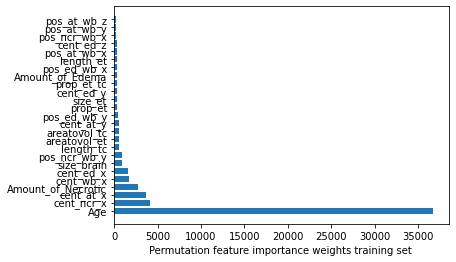

In [ ]:
#feature importance and feature permutation
!pip install shap
!pip install lime
!pip install eli5
!pip install graphviz
!pip install pdpbox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor	# To fit the svm classifier
from sklearn import utils
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing,linear_model
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score
from sklearn.feature_selection import RFE, RFECV
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot
import eli5
from eli5.sklearn import PermutationImportance

df = pd.read_excel('/content/drive/MyDrive/journalwork/image_features.xlsx')

df = df[df['Resection Status'] == 'GTR']
df = df[df['Survival Days'] != 'ALIVE (361 days later)']
df = df.fillna(-1)
df = df[df['Survival Days'] != -1]
df1= df.copy()
x_train=df1.drop(columns=['ID','Resection Status','Survival Days' ])
#x = df.values
#x_train = x[:,3:]
print(x_train.shape)
#scaler = StandardScaler()
#scaler.fit(x_train[:,:])
#print(scaler.mean_,scaler.var_)
#x_train[:,:] = scaler.transform(x_train[:,:])





y_train = df['Survival Days']
#y_train=np.float32(y_train) #added for permutation_information
print(type(y_train))
print(len(y_train))
print(y_train)
RANDOM_STATE = 123
X_train, X_tst, y_train, y_tst = train_test_split(x_train, y_train, test_size=0.25,

                                                    random_state=RANDOM_STATE)
#for imagefeatures grid search parameters:'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 12, 'n_estimators': 500

clf = RandomForestRegressor(max_depth= 4, max_features='auto', min_samples_leaf= 12, n_estimators=500,random_state=1)#KNeighborsRegressor()#XGBRegressor()#DecisionTreeRegressor()
   #.fit(x_trn, y_trn)

   #for recursive feature elimination
   #rfe = RFE(estimator=clf, n_features_to_select=25, step=1,verbose=1)
   #rfe = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),scoring='accuracy')
   #rfe.fit(x_trn, y_trn)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_tst)
print(f"Test MSE: {mean_squared_error(y_tst, y_predict).round(2)}")
print(f"Test r2score:{r2_score(y_tst, y_predict).round(2)}")

perm_test = PermutationImportance(clf,scoring='neg_mean_squared_error',n_iter=100, random_state=RANDOM_STATE, cv="prefit")

# fit and see the permuation importances
perm_test.fit(X_train, y_train)

import seaborn as sns
import matplotlib.pyplot as plt
imp_df = eli5.explain_weights_df(perm_test)

label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(X_tst.columns))], 'feature_name': X_tst.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")

# Reorder by importance
ordered_df = imp_df.sort_values(by='weight',ascending=False)
imp_range=range(1,len(imp_df.index)+1)


## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
bars1 = bars [:25]
height1 = height[:25]
ci = 1.96 * ordered_df['std']
ci1=ci[:25]
y_pos = np.arange(len(bars1))
rows= zip(imp_range,height,bars)
with open('permutation_importance_flair.csv', 'w') as f: #centroid of wholebrain updated in this file
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)
    #print('Column: %d, %.6f, %s, %s\n' % (i, height1, bars1, df.columns[i] ),file=f)
print("weights\n",height1)
print("features name",bars1)
# Create horizontal bars
plt.barh(y_pos, height1)

# Create names on the y-axis
plt.yticks(y_pos, bars1)

plt.xlabel("Permutation feature importance weights training set ")
#plt.tight_layout()
plt.savefig('featureimportance.png',dpi=300,bbox_inches='tight')
# Show graphic
plt.show()


In [ ]:
filename = 'Trained_Model_permspearman.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#OS for training set
X = pd.read_excel('/content/drive/MyDrive/journalwork/train_image_pyrfeatures_log_book3.xlsx')
x = X.values
##nx_test = x[130:,1:]
x_test = x[:,3:]
patient_id = x[:,0]

survival_data = []


print('\nSurvival Prediction is:')

for i in range(len(x_test)):
    survival_data.append({'ID': patient_id[i],'survival_days':float(loaded_model.predict([x_test[i]]))})
    with open('os_train_perimp_spearman_rfrgridbook3_new.csv', 'w') as f:
        w = csv.DictWriter(f,['ID','survival_days'])
        w.writeheader()
        for j in survival_data:
            w.writerow(j)
        print(float(loaded_model.predict([x_test[i]])))


Survival Prediction is:
410.88231334932067
575.0479425130393
397.4158570683765
534.8517177980451
465.94912768224685
448.77563995005244
437.0714576997319
420.15067896330834
575.5659892028797
563.5049607498551
494.8932443751987
450.1482608009391
528.3892065623551
420.20312116570545
311.595816227411
495.3228462401588
493.3816459137516
492.68959036706025
293.79598078181493
442.5894238517661
517.7004862423912
562.1550383269328
428.1783599973366
521.0666399069145
497.0909636820923
561.6834747191793
432.28901300072516
342.97125320946753
374.62055382194694
473.2844536051583
387.6973406263905
443.1904916585669
419.8854308045836
694.3493704080456
462.9129570348309
333.24873492947773
384.7989211582577
419.2639309982247
411.43403456055626
477.38410197034574
559.764671504666
472.2327638356442
595.366084437946
474.34932279799074
430.40489327885575
531.2080685754914
441.9583513775605
553.9442231982347
393.91267650732055
557.0600011208285
508.0055610812749
416.66309674696504
495.92481510167886
389.04

In [ ]:
X = pd.read_excel('/content/drive/MyDrive/journalwork/val_imagepyrfeatures_log_book3.xlsx')
x = X.values
##nx_test = x[130:,1:]
x_test = x[:,3:]
datalist = x_test.tolist()
datalist = np.float32(datalist)
x_test = np.array(datalist)
x_test = np.nan_to_num(x_test)
patient_id = x[:,0]

survival_data = []


print('\nSurvival Prediction is:')

for i in range(len(x_test)):
    survival_data.append({'ID': patient_id[i],'survival_days':float(loaded_model.predict([x_test[i]]))})
    with open('val_os_perimp_spearman_rfrgridbook3_new.csv', 'w') as f:
        w = csv.DictWriter(f,['ID','survival_days'])
        w.writeheader()
        for j in survival_data:
            w.writerow(j)
        print(float(loaded_model.predict([x_test[i]])))



Survival Prediction is:
505.4783106665361
525.296840622444
578.3470580530227
517.1075931071937
409.7650006464324
587.6378874746755
491.2200955965603
338.37321010028296
459.71509922756127
446.534742771922
453.78397059427044
468.7233050485411
521.0387639185969
471.5018551365572
527.7201997258347
517.6314366289741
461.391121811174
520.754719063444
379.9677300076793
495.46379841403285
544.6967981536638
425.9177526054032
486.82076613858857
580.8573792471075
481.43593831442087
566.5890718554946
475.970025828616
421.7673424924003
437.4394033079492


In [ ]:
#grid search
#grid search
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor	# To fit the svm classifier
from sklearn import utils
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing,linear_model
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import RFE, RFECV
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot
#train_new:Best: 0.136997 using {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 50}
df = pd.read_excel('/content/Train_ens9_new.xlsx')
#print("x",df.shape)
df = df[df['Resection Status'] == 'GTR']
print("x",df.shape)
df = df[df['Survival Days'] != 'ALIVE (361 days later)']
df = df.fillna(-1)
df = df[df['Survival Days'] != -1]
x = df.values

x_train = x[:,3:]
print(x_train.shape)
#scaler = StandardScaler()
#scaler.fit(x_train[:,:])
#print(scaler.mean_,scaler.var_)
#x_train[:,:] = scaler.transform(x_train[:,:])


datalist = x_train.tolist()

#x_train=np.array(datalist, dtype=np.float32)
datalist = np.float32(datalist)
x_train = np.array(datalist)
x_train = np.nan_to_num(x_train)

y_train = x[:,2]
#y_train=np.float32(y_train) #added for permutation_information

y_train = utils.column_or_1d(y_train.ravel(), warn=True)

#Applying K fold cross validation
kfold = KFold(n_splits=5, shuffle=False)

param_grid = {
    'n_estimators': [45, 50, 70, 100,150,200, 500],
    'max_features': [None, 'sqrt', 'log2'],#removed 'auto' parameter from here
    'max_depth' : [3,4,5,6,7,8,9,10],
    'min_samples_leaf': [4,6,8,10,12]}

##--------------------------------------------------------------------------##


   # various Kernels
   #clf = svm.SVC(kernel='rbf', gamma=10, C=C).fit(x_trn, y_trn)
   #clf = svm.LinearSVC(max_iter=100000).fit(x_trn, y_trn)
   # for feature importance
   #clf = KNeighborsRegressor()#XGBRegressor()#DecisionTreeRegressor()#RandomForestRegressor(n_estimators=100)
clf=RandomForestRegressor(random_state=1)
#clf = MLPRegressor(random_state=1, max_iter=800,early_stopping=True)
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
grid_result=CV_rfc.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
#grid search
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor	# To fit the svm classifier
from sklearn import utils
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing,linear_model
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import RFE, RFECV
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot
#for book3 Best: 0.092385 using {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 800}
#for book2 Best: 0.111190 using {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 100}
df = pd.read_excel('/content/drive/MyDrive/journalwork/train_image_pyrfeatures_log_book3.xlsx')
df = df[df['Resection Status'] == 'GTR']
df = df[df['Survival Days'] != 'ALIVE (361 days later)']
df = df.fillna(-1)
df = df[df['Survival Days'] != -1]
x = df.values
x_train = x[:,3:]
print(x_train.shape)
#scaler = StandardScaler()
#scaler.fit(x_train[:,:])
#print(scaler.mean_,scaler.var_)
#x_train[:,:] = scaler.transform(x_train[:,:])


datalist = x_train.tolist()

#x_train=np.array(datalist, dtype=np.float32)
datalist = np.float32(datalist)
x_train = np.array(datalist)
x_train = np.nan_to_num(x_train)

y_train = x[:,2]
#y_train=np.float32(y_train) #added for permutation_information

y_train = utils.column_or_1d(y_train.ravel(), warn=True)

#Applying K fold cross validation
kfold = KFold(n_splits=5, shuffle=False)

param_grid = {
    'hidden_layer_sizes': [(100,)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'min_samples_leaf': [4,6,8,10,12]}

##--------------------------------------------------------------------------##


   # various Kernels
   #clf = svm.SVC(kernel='rbf', gamma=10, C=C).fit(x_trn, y_trn)
   #clf = svm.LinearSVC(max_iter=100000).fit(x_trn, y_trn)
   # for feature importance
   #clf = KNeighborsRegressor()#XGBRegressor()#DecisionTreeRegressor()#RandomForestRegressor(n_estimators=100)
clf=RandomForestRegressor(random_state=1)
   #clf = MLPRegressor(random_state=1, max_iter=800,early_stopping=True)
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
grid_result=CV_rfc.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))